## Step 1.  Authenticate GEE , install and required packeges

In [10]:
# Set up the current working directory
import os

In [11]:
os.getcwd()

'C:\\Users\\LEBELA TADELE MELESE'

In [9]:
os.mkdir('PDSI_predicition')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'PDSI_predicition'

In [12]:
os.chdir('C:\\Users\\LEBELA TADELE MELESE\\PDSI_predicition')

In [13]:
os.getcwd()

'C:\\Users\\LEBELA TADELE MELESE\\PDSI_predicition'

In [1]:
import ee
import geemap
ee.Authenticate()

True

In [ ]:
!pip install pandas numpy matplotlib geopandas rasterio scikit-learn

## Step 2. Preprocess and export climate variables (from Terraclimate) for Ethiopia

In [92]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

# Define the area of interest (Ethiopia boundary).
ethiopia = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Ethiopia'))

# Load TerraClimate dataset.
terraclimate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")

# Filter data for the years of interest (e.g., 1980-2023) and Ethiopia
start_date = '1980-01-01'
end_date = '2023-12-31'

# Define the bands of interest
bands = ['pdsi', 'pr', 'tmmx', 'tmmn', 'aet', 'pet', 'soil', 'srad', 'vpd','vs', 'vap' , 'swe' , 'ro' , 'def']

# Filter and select bands
terraclimate_filtered = terraclimate.filterDate(start_date, end_date).select(bands)

# Clip to Ethiopia boundary
terraclimate_ethiopia = terraclimate_filtered.map(lambda image: image.clip(ethiopia))

# Define the scale factors for each variable
scale_factors = {
    'aet': 0.1,
    'def': 0.1,
    'pdsi': 0.01,
    'pet': 0.1,
    'pr': 0,
    'ro': 0.1,
    'soil': 0.1,
    'srad': 0.1,
    'swe': 0.1,
    'tmmn': 0.1,
    'tmmx': 0.1,
    'vap': 0.001,
    'vpd': 0.01,
    'vs': 1  # No scale factor provided
}

def apply_scale(image):
    # Apply scale factors to each band
    scaled_image = image
    for band in bands:
        if band in scale_factors:
            # Apply scale factor to the band
            scaled_image = scaled_image.addBands(image.select(band).multiply(scale_factors[band]).rename(band))
    return scaled_image

# Apply scale factors to the image collection
scaled_terraclimate_ethiopia = terraclimate_ethiopia.map(apply_scale)

# Aggregate monthly data
monthly_terraclimate_ethiopia = scaled_terraclimate_ethiopia.mean()

# Verify band names in the aggregated image
def print_band_names(image):
    bands = image.bandNames().getInfo()
    print("Bands in the image:", bands)

# Print band names to debug
print_band_names(monthly_terraclimate_ethiopia)

# Export each variable to Google Drive
for band in bands:
    # Select the band of interest
    if band in monthly_terraclimate_ethiopia.bandNames().getInfo():
        image = monthly_terraclimate_ethiopia.select(band)
        
        # Export the data to Google Drive
        export_task = ee.batch.Export.image.toDrive(
            image=image,
            description=f'Ethiopia_{band}_Monthly_Scaled',
            folder='EarthEngine',
            scale=4000,
            region=ethiopia.geometry(),
            fileFormat='GeoTIFF'
        )
        
        # Start the export task
        export_task.start()
    else:
        print(f"Band {band} not found in the aggregated image.")

print("Export tasks have been started.")


Bands in the image: ['pdsi', 'pr', 'tmmx', 'tmmn', 'aet', 'pet', 'soil', 'srad', 'vpd', 'vs', 'vap', 'swe', 'ro', 'def', 'pdsi_1', 'pr_1', 'tmmx_1', 'tmmn_1', 'aet_1', 'pet_1', 'soil_1', 'srad_1', 'vpd_1', 'vs_1', 'vap_1', 'swe_1', 'ro_1', 'def_1']
Export tasks have been started.


### Export and Load the Ethiopia boundary 

In [ ]:
# Load the Ethiopia boundary from the FAO GAUL dataset
ethiopia = ee.FeatureCollection("FAO/GAUL/2015/level0") \
             .filter(ee.Filter.eq('ADM0_NAME', 'Ethiopia'))

# Define the export task
task = ee.batch.Export.table.toDrive(
    collection=ethiopia,
    description='Ethiopia_Boundary',
    folder='EarthEngine',  
    fileFormat='SHP'
)

# Start the export task
task.start()
# Load the Ethiopia boundary shapefile
ethiopia_boundary = gpd.read_file('Ethiopia_Boundary.shp')

## Step 3.  Load the GeoTIFF files form Directory

In [93]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.mask import mask

# Load the GeoTIFF files 
with rasterio.open('Ethiopia_PDSI_Monthly_Scaled.tif') as src:
    pdsi_data = src.read(1)
    pdsi_meta = src.meta
with rasterio.open('Ethiopia_Pr_Monthly_Scaled.tif') as src:
    pr_data = src.read(1)
    pr_meta = src.meta
with rasterio.open('Ethiopia_TMMX_Monthly_Scaled.tif') as src:
    tmmx_data = src.read(1)
    tmmx_meta = src.meta
with rasterio.open('Ethiopia_tmmn_Monthly_Scaled.tif') as src:
    tmmn_data = src.read(1)
    tmmn_meta = src.meta
with rasterio.open('Ethiopia_aet_Monthly_Scaled.tif') as src:
    aet_data = src.read(1)
    aet_meta = src.meta
with rasterio.open('Ethiopia_pet_Monthly_Scaled.tif') as src:
    pet_data = src.read(1)
    pet_meta = src.meta
with rasterio.open('Ethiopia_soil_Monthly_Scaled.tif') as src:
    soil_data = src.read(1)
    soil_meta = src.meta
with rasterio.open('Ethiopia_srad_Monthly_Scaled.tif') as src:
    srad_data = src.read(1)
    srad_meta = src.meta
with rasterio.open('Ethiopia_vpd_Monthly_Scaled.tif') as src:
    vpd_data = src.read(1)
    vpd_meta = src.meta
with rasterio.open('Ethiopia_vs_Monthly_Scaled.tif') as src:
    vs_data = src.read(1)
    vs_meta = src.meta
with rasterio.open('Ethiopia_vap_Monthly_Scaled.tif') as src:
    vap_data = src.read(1)
    vap_meta = src.meta
with rasterio.open('Ethiopia_ro_Monthly_Scaled.tif') as src:
    ro_data = src.read(1)
    ro_meta = src.meta
with rasterio.open('Ethiopia_swe_Monthly_Scaled.tif') as src:
    swe_data = src.read(1)
    swe_meta = src.meta
with rasterio.open('Ethiopia_def_Monthly_Scaled.tif') as src:
    def_data = src.read(1)
    def_meta = src.meta

### Generate Masked Data and Metadata

In [95]:
# Load the Ethiopia boundary shapefile
ethiopia_boundary = gpd.read_file('Ethiopia_Boundary.shp')

# Define a function to load and mask a variable
def load_and_mask_variable(filepath, boundary):
    with rasterio.open(filepath) as src:
        # Read the data
        data = src.read(1)
        # Mask the data using the Ethiopia boundary
        masked_data, transform = mask(src, [boundary.geometry[0]], crop=True)
        # Update metadata after cropping
        meta = src.meta.copy()
        meta.update({
            "height": masked_data.shape[1],
            "width": masked_data.shape[2],
            "transform": transform
        })
    return masked_data, meta

# Example paths to your GeoTIFF files (update these with your actual file paths)
pdsi_path = 'Ethiopia_PDSI_Monthly_Scaled.tif'
pr_path = 'Ethiopia_Pr_Monthly_Scaled.tif'
tmmx_path = 'Ethiopia_TMMX_Monthly_Scaled.tif'
tmmn_path = 'Ethiopia_tmmn_Monthly_Scaled.tif'
aet_path = 'Ethiopia_aet_Monthly_Scaled.tif'
pet_path = 'Ethiopia_pet_Monthly_Scaled.tif'
soil_path = 'Ethiopia_soil_Monthly_Scaled.tif'
srad_path = 'Ethiopia_srad_Monthly_Scaled.tif'
vpd_path = 'Ethiopia_vpd_Monthly_Scaled.tif'
vs_path = 'Ethiopia_vs_Monthly_Scaled.tif'
vap_path = 'Ethiopia_vap_Monthly_Scaled.tif'
ro_path = 'Ethiopia_ro_Monthly_Scaled.tif'
swe_path = 'Ethiopia_swe_Monthly_Scaled.tif'
def_path = 'Ethiopia_def_Monthly_Scaled.tif'
# Load and mask PDSI
pdsi_data, pdsi_meta = load_and_mask_variable(pdsi_path, ethiopia_boundary)

# Load and mask Precipitation
pr_data, ppt_meta = load_and_mask_variable(pr_path, ethiopia_boundary)

# Load and mask Maximum Temperature
tmmx_data, tmmx_meta = load_and_mask_variable(tmmx_path, ethiopia_boundary)

# Load and mask Minimum Temperature
tmmn_data, tmmn_meta = load_and_mask_variable(tmmn_path, ethiopia_boundary)
# Load and mask aet
aet_data, aet_meta = load_and_mask_variable(aet_path, ethiopia_boundary)

# Load and mask pet
pet_data, pet_meta = load_and_mask_variable(pet_path, ethiopia_boundary)

# Load and mask soil
soil_data, soil_meta = load_and_mask_variable(soil_path, ethiopia_boundary)

# Load and mask soil
srad_data, srad_meta = load_and_mask_variable(srad_path, ethiopia_boundary)
# Load and mask vpd
vpd_data, vpd_meta = load_and_mask_variable(vpd_path, ethiopia_boundary)
# Load and mask vs
vs_data, vs_meta = load_and_mask_variable(vs_path, ethiopia_boundary)

# Load and mask vap
vap_data, vap_meta = load_and_mask_variable(vap_path, ethiopia_boundary)

# Load and mask ro
ro_data, ro_meta = load_and_mask_variable(ro_path, ethiopia_boundary)
# Load and mask swe
swe_data, swe_meta = load_and_mask_variable(swe_path, ethiopia_boundary)
# Load and mask swe
def_data, def_meta = load_and_mask_variable(def_path, ethiopia_boundary)

##  Spatial Subsetting
### Save the masked variables

In [97]:
# Save the masked PDSI data
with rasterio.open('Ethiopia_PDSI_Masked.tif', 'w', **pdsi_meta) as dest:
    dest.write(pdsi_data)

# Save the masked Precipitation data
with rasterio.open('Ethiopia_Precipitation_Masked.tif', 'w', **ppt_meta) as dest:
    dest.write(pr_data)

# Save the masked Maximum Temperature data
with rasterio.open('Ethiopia_Temperature_Max_Masked.tif', 'w', **tmmx_meta) as dest:
    dest.write(tmmx_data)

# Save the masked Minimum Temperature data
with rasterio.open('Ethiopia_Temperature_Min_Masked.tif', 'w', **tmmn_meta) as dest:
    dest.write(tmmn_data)
# Save the masked aet data
with rasterio.open('Ethiopia_Aet_Masked.tif', 'w', **aet_meta) as dest:
    dest.write(aet_data)

# Save the masked pet data
with rasterio.open('Ethiopia_Pet_Masked.tif', 'w', **pet_meta) as dest:
    dest.write(pet_data)

# Save the masked soil data
with rasterio.open('Ethiopia_Soil_Masked.tif', 'w', **soil_meta) as dest:
    dest.write(soil_data)

# Save the masked srad data
with rasterio.open('Ethiopia_SrAD_Masked.tif', 'w', **srad_meta) as dest:
    dest.write(srad_data)
# Save the masked vpd data
with rasterio.open('Ethiopia_VPD_Masked.tif', 'w', **vpd_meta) as dest:
    dest.write(vpd_data)

# Save the masked vs data
with rasterio.open('Ethiopia_Vs_Masked.tif', 'w', **vs_meta) as dest:
    dest.write(vs_data)

# Save the masked vap data
with rasterio.open('Ethiopia_Vap_Masked.tif', 'w', **vap_meta) as dest:
    dest.write(vap_data)

# Save the masked ro data
with rasterio.open('Ethiopia_Ro_Masked.tif', 'w', **ro_meta) as dest:
    dest.write(ro_data)
# Save the masked swe data
with rasterio.open('Ethiopia_Swe_Masked.tif', 'w', **swe_meta) as dest:
    dest.write(swe_data)
    # Save the masked swe data
with rasterio.open('Ethiopia_Def_Masked.tif', 'w', **def_meta) as dest:
    dest.write(def_data)

## Aggregate data


In [25]:
!pip install xarray

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from pyproj import CRS

In [98]:
# Function to load, mask, and aggregate data
def load_mask_and_aggregate(path, boundary, time_freq):
    # Load and mask the variable
    data, meta = load_and_mask_variable(path, boundary)
    
    # Check if data is 3D or 4D
    if len(data.shape) == 3:
        data = np.expand_dims(data, axis=0)  # Add a dummy time dimension if missing
    
    # Determine dimensions and coordinates
    dims = ['time', 'band', 'y', 'x'] if len(data.shape) == 4 else ['time', 'y', 'x']
    num_time = data.shape[0]
    
    # Create an xarray DataArray with dummy time dimension
    time_coords = pd.date_range(start='1981-01-01', periods=num_time, freq='YE')
    
    # Handle metadata attributes
    attrs = {
        'driver': meta['driver'],
        'dtype': meta['dtype'],
        'transform': meta['transform']
    }
    
    # Set a default value for 'nodata' if it's None
    nodata_value = meta.get('nodata', -9999)
    if nodata_value is not None:
        attrs['nodata'] = nodata_value
    
    # Convert CRS to EPSG code or WKT string if it's a CRS object
    crs = meta.get('crs', None)
    if isinstance(crs, CRS):
        crs_str = crs.to_epsg()
        if crs_str is not None:
            attrs['crs'] = f"EPSG:{crs_str}"
        else:
            attrs['crs'] = crs.to_string()
    elif isinstance(crs, str):
        attrs['crs'] = crs
    
    data_array = xr.DataArray(
        data=data,
        dims=dims,
        coords={
            'time': time_coords,
            'band': np.arange(data.shape[1]) if 'band' in dims else None,
            'y': np.arange(data.shape[-2]),
            'x': np.arange(data.shape[-1])
        },
        attrs=attrs
    )
    
    # Perform temporal aggregation
    aggregated_data = data_array.resample(time=time_freq).mean(dim='time')


    return aggregated_data

# Define the time frequency for aggregation (e.g., 'A' for annual, 'YE' for year-end)
time_frequency = 'YE'

# Load, mask, and aggregate PDSI
pdsi_aggregated = load_mask_and_aggregate(pdsi_path, ethiopia_boundary, time_frequency)
pdsi_aggregated.to_netcdf('Ethiopia_PDSI_Aggregated.nc')

# Load, mask, and aggregate Precipitation
pr_aggregated = load_mask_and_aggregate(pr_path, ethiopia_boundary, time_frequency)
pr_aggregated.to_netcdf('Ethiopia_Precipitation_Aggregated.nc')

# Load, mask, and aggregate Maximum Temperature
tmax_aggregated = load_mask_and_aggregate(tmmx_path, ethiopia_boundary, time_frequency)
tmax_aggregated.to_netcdf('Ethiopia_Tmax_Aggregated.nc')

# Load, mask, and aggregate Minimum Temperature
tmin_aggregated = load_mask_and_aggregate(tmmn_path, ethiopia_boundary, time_frequency)
tmin_aggregated.to_netcdf('Ethiopia_Tmin_Aggregated.nc')

# Load, mask, and aggregate AET
aet_aggregated = load_mask_and_aggregate(aet_path, ethiopia_boundary, time_frequency)
aet_aggregated.to_netcdf('Ethiopia_AET_Aggregated.nc')

# Load, mask, and aggregate PET
pet_aggregated = load_mask_and_aggregate(pet_path, ethiopia_boundary, time_frequency)
pet_aggregated.to_netcdf('Ethiopia_PET_Aggregated.nc')

# Load, mask, and aggregate Soil
soil_aggregated = load_mask_and_aggregate(soil_path, ethiopia_boundary, time_frequency)
soil_aggregated.to_netcdf('Ethiopia_Soil_Aggregated.nc')

# Load, mask, and aggregate SRAD
srad_aggregated = load_mask_and_aggregate(srad_path, ethiopia_boundary, time_frequency)
srad_aggregated.to_netcdf('Ethiopia_SRAD_Aggregated.nc')

# Load, mask, and aggregate VPD
vpd_aggregated = load_mask_and_aggregate(vpd_path, ethiopia_boundary, time_frequency)
vpd_aggregated.to_netcdf('Ethiopia_VPD_Aggregated.nc')


# Load, mask, and aggregate vs
vs_aggregated = load_mask_and_aggregate(pet_path, ethiopia_boundary, time_frequency)
vs_aggregated.to_netcdf('Ethiopia_VS_Aggregated.nc')

# Load, mask, and aggregate vap
vap_aggregated = load_mask_and_aggregate(soil_path, ethiopia_boundary, time_frequency)
vap_aggregated.to_netcdf('Ethiopia_VAP_Aggregated.nc')

# Load, mask, and aggregate ro
srad_aggregated = load_mask_and_aggregate(srad_path, ethiopia_boundary, time_frequency)
srad_aggregated.to_netcdf('Ethiopia_RO_Aggregated.nc')

# Load, mask, and aggregate swe
vpd_aggregated = load_mask_and_aggregate(vpd_path, ethiopia_boundary, time_frequency)
vpd_aggregated.to_netcdf('Ethiopia_SWE_Aggregated.nc')

# Load, mask, and aggregate def
def_aggregated = load_mask_and_aggregate(vpd_path, ethiopia_boundary, time_frequency)
def_aggregated.to_netcdf('Ethiopia_DEF_Aggregated.nc')



### Export the Date, Latitude, Longitude, and other variables value in csv from GEE

In [14]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

# Define the area of interest (Ethiopia boundary).
ethiopia = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Ethiopia'))

# Load the TerraClimate dataset and filter by date and bands of interest.
start_date = '1981-01-01'
end_date = '2023-12-31'
bands = ['pdsi', 'pr', 'tmmx', 'tmmn', 'aet', 'pet', 'soil', 'srad', 'vpd', 'vs', 'vap', 'swe', 'ro','def']

# Load the dataset and filter by date and bands
terraclimate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").filterDate(start_date, end_date).select(bands)

# Clip the data to the Ethiopia boundary
terraclimate_ethiopia = terraclimate.map(lambda image: image.clipToCollection(ethiopia))

# Function to add latitude and longitude bands to each image
def add_latlon(image):
    latlon = ee.Image.pixelLonLat()  # Create an image with lat/lon bands
    return image.addBands(latlon)    # Add lat/lon bands to the image

# Function to add the date as a property to each feature
def add_date_property(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return image.set('Date', date)

# Apply the function to add latitude, longitude, and date to the TerraClimate data
terraclimate_with_latlon_date = terraclimate_ethiopia.map(add_latlon).map(add_date_property)

# Function to sample data using reduceRegions
def sample_data(image):
    # Define the region to sample data from
    sampled = image.reduceRegions(
        collection=ethiopia,  # Sample from the boundary feature collection
        reducer=ee.Reducer.mean(),
        scale=4000
    )
    # Add the date property to each feature in the sampled collection
    return sampled.map(lambda feature: feature.set('Date', image.get('Date')))

# Apply the sampling function to each image in the collection
sampled_collection = terraclimate_with_latlon_date.map(sample_data).flatten()

# Function to export data to CSV
def export_csv(collection, description_prefix, folder='EarthEngine'):
    export_task = ee.batch.Export.table.toDrive(
        collection=collection,
        description=description_prefix,
        fileFormat='CSV',
        folder=folder
    )
    export_task.start()
    print(f"Export task for {description_prefix} started. Check your Google Drive for the CSV file.")

# Export the sampled data
export_csv(sampled_collection, 'Ethiopia_Terra_Climate_Data')


EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

In [15]:
# check
df = pd.read_csv('Ethiopia_Terra_Climate_Data.csv')
df.head()
df.columns

Index(['system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'Date',
       'EXP0_YEAR', 'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'aet',
       'def', 'latitude', 'longitude', 'pdsi', 'pet', 'pr', 'ro', 'soil',
       'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', '.geo'],
      dtype='object')

### Scaled the data to convert from raw to usable for further analysis

In [16]:
# Load the TerraClimate data exported from GEE
df = pd.read_csv('Ethiopia_Terra_Climate_Data.csv')

'''
# ////////////  Scale Factors/////////////////////////////////////////////////
    'aet': 0.1,
    'def': 0.1,
    'pdsi': 0.01,
    'pet': 0.1,
    'pr': 1,
    'ro': 1,
    'soil': 0.1,
    'srad': 0.1,
    'swe': 1,
    'tmmn': 0.1,
    'tmmx': 0.1,
    'vap': 0.001,
    'vpd': 0.01,
    'vs': 0.01           

    '''
# Apply scale factors to the appropriate columns
df['tmmx'] = df['tmmx'] * 0.1
df['tmmn'] = df['tmmn'] * 0.1
df['soil'] = df['soil'] * 0.1
df['vpd'] = df['vpd'] * 0.01
df['pdsi'] = df['pdsi'] * 0.01
df['aet'] = df['aet'] * 0.1
df['pet'] = df['pet'] * 0.1
df['srad'] = df['srad'] * 0.1
df['def'] = df['def'] * 0.1
df['pr'] = df['pr'] * 1
df['ro'] = df['aet'] * 1
df['vap'] = df['vap'] * 0.001
df['swe'] = df['swe'] * 1


# Verify the scaled data
print(df.head())

# Save the scaled data if needed
df.to_csv('Ethio_terraclimate_Data_scaled.csv', index=False)


                  system:index  ADM0_CODE ADM0_NAME DISP_AREA        Date  \
0  198101_00000000000000000038         79  Ethiopia        NO  1981-01-01   
1  198102_00000000000000000038         79  Ethiopia        NO  1981-02-01   
2  198103_00000000000000000038         79  Ethiopia        NO  1981-03-01   
3  198104_00000000000000000038         79  Ethiopia        NO  1981-04-01   
4  198105_00000000000000000038         79  Ethiopia        NO  1981-05-01   

   EXP0_YEAR        STATUS  STR0_YEAR  Shape_Area  Shape_Leng  ...         ro  \
0       3000  Member State       1000   92.869258   50.380131  ...   8.110974   
1       3000  Member State       1000   92.869258   50.380131  ...  16.474987   
2       3000  Member State       1000   92.869258   50.380131  ...  75.961518   
3       3000  Member State       1000   92.869258   50.380131  ...  86.065355   
4       3000  Member State       1000   92.869258   50.380131  ...  65.481602   

        soil        srad  swe       tmmn       tmm

In [104]:
# Display basic information about the dataset
print(df.info())

# Handle missing values (if any)
df = df.dropna()

# Convert time column to datetime format
# df['date'] = pd.to_datetime(df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  516 non-null    object 
 1   ADM0_CODE     516 non-null    int64  
 2   ADM0_NAME     516 non-null    object 
 3   DISP_AREA     516 non-null    object 
 4   Date          516 non-null    object 
 5   EXP0_YEAR     516 non-null    int64  
 6   STATUS        516 non-null    object 
 7   STR0_YEAR     516 non-null    int64  
 8   Shape_Area    516 non-null    float64
 9   Shape_Leng    516 non-null    float64
 10  aet           516 non-null    float64
 11  def           516 non-null    float64
 12  latitude      516 non-null    float64
 13  longitude     516 non-null    float64
 14  pdsi          516 non-null    float64
 15  pet           516 non-null    float64
 16  pr            516 non-null    float64
 17  ro            516 non-null    float64
 18  soil          516 non-null    

In [108]:
# Set the time column as index
df.set_index('Date', inplace=True)

In [109]:
df.head()

system:index  ADM0_CODE ADM0_NAME DISP_AREA  \
Date                                                                     
1981-01-01  198101_00000000000000000038         79  Ethiopia        NO   
1981-02-01  198102_00000000000000000038         79  Ethiopia        NO   
1981-03-01  198103_00000000000000000038         79  Ethiopia        NO   
1981-04-01  198104_00000000000000000038         79  Ethiopia        NO   
1981-05-01  198105_00000000000000000038         79  Ethiopia        NO   

            EXP0_YEAR        STATUS  STR0_YEAR  Shape_Area  Shape_Leng  \
Date                                                                     
1981-01-01       3000  Member State       1000   92.869258   50.380131   
1981-02-01       3000  Member State       1000   92.869258   50.380131   
1981-03-01       3000  Member State       1000   92.869258   50.380131   
1981-04-01       3000  Member State       1000   92.869258   50.380131   
1981-05-01       3000  Member State       1000   92.869258   50.380131   

                  aet  ...         ro       soil        srad  swe       tmmn  \
Date                   ...                                                     
1981-01-01   8.110974  ...   8.110974  18.136619  253.863398  0.0  14.164818   
1981-02-01  16.474987  ...  16.474987  14.459879  260.609263  0.0  14.572312   
1981-03-01  75.961518  ...  75.961518  27.165537  220.083588  0.0  17.117157   
1981-04-01  86.065355  ...  86.065355  42.538872  245.811232  0.0  17.084674   
1981-05-01  65.481602  ...  65.481602  38.543301  251.227387  0.0  17.217060   

                 tmmx       vap       vpd          vs  \
Date                                                    
1981-01-01  30.774718  1.509087  1.610104  222.656243   
1981-02-01  31.322946  1.456496  1.765419  231.999600   
1981-03-01  29.780160  1.620867  1.563144  177.824586   
1981-04-01  29.753378  1.715492  1.463258  176.660039   
1981-05-01  30.373915  1.849225  1.415150  224.176060   

                                                         .geo  
Date                                                           
1981-01-01  {"type":"Polygon","coordinates":[[[32.99993854...  
1981-02-01  {"type":"Polygon","coordinates":[[[32.99993854...  
1981-03-01  {"type":"Polygon","coordinates":[[[32.99993854...  
1981-04-01  {"type":"Polygon","coordinates":[[[32.99993854...  
1981-05-01  {"type":"Polygon","coordinates":[[[32.99993854...  

[5 rows x 26 columns]

In [111]:
df.columns

Index(['system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
       'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'aet', 'def',
       'latitude', 'longitude', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad',
       'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', '.geo'],
      dtype='object')

In [17]:
# Drop any rows with missing values
df.dropna(inplace=True)
df_cleaned = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
       'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude','swe'])


In [37]:
df_cleaned.head(50)

Date         aet         def      pdsi         pet          pr  \
0   1981-01-01    8.110974  143.023862 -2.954699  151.136004    1.878243   
1   1981-02-01   16.474987  130.389708 -3.023392  146.865089   13.466370   
2   1981-03-01   75.961518   62.851547 -1.097885  138.813319   94.600596   
3   1981-04-01   86.065355   56.230348  0.373450  142.295486  118.330921   
4   1981-05-01   65.481602   88.917063 -0.012590  154.399204   65.913244   
5   1981-06-01   40.393545  104.716540 -1.036689  145.110246   39.842217   
6   1981-07-01   64.282721   61.869759 -1.026200  126.153082  134.119773   
7   1981-08-01   70.072643   62.426101 -0.562494  132.499172  158.082159   
8   1981-09-01   70.569552   63.829437 -0.511421  134.400048   92.338880   
9   1981-10-01   61.317272   82.252711 -0.991086  143.570751   43.835549   
10  1981-11-01   34.517361   99.087763 -1.506392  133.605504   22.360698   
11  1981-12-01   16.013073  123.305347 -1.868152  139.318880    4.066384   
12  1982-01-01   24.212862  117.583342 -1.608387  141.796128   20.015424   
13  1982-02-01   38.462736   97.550999 -1.046160  136.014493   37.244198   
14  1982-03-01   51.644415  116.777793 -0.695217  168.422103   52.402827   
15  1982-04-01   72.472017   78.006436 -0.678078  150.478759   90.689282   
16  1982-05-01   90.292114   53.327442  0.313242  143.619767  128.396318   
17  1982-06-01   47.813184   91.109235 -0.019920  138.922609   62.370141   
18  1982-07-01   62.144101   71.518318 -0.760525  133.663374   91.544365   
19  1982-08-01   67.553231   63.828925 -1.059947  131.383283  120.185255   
20  1982-09-01   70.743030   68.601626 -1.320020  139.345519   75.981593   
21  1982-10-01  101.882076   29.157993  0.631390  131.040383  139.716616   
22  1982-11-01   75.463240   40.862492  2.222873  116.325909   84.037504   
23  1982-12-01   39.023807   89.921770  2.590533  128.945623   19.247248   
24  1983-01-01   22.310572  115.282758  2.401795  137.593393    6.913037   
25  1983-02-01   32.802385   95.688589  2.321735  128.491404   27.569495   
26  1983-03-01   33.493480  127.019817  1.818954  160.513268   30.332789   
27  1983-04-01   82.455923   64.920154  1.681901  147.376176   97.512976   
28  1983-05-01   95.060829   48.558143  2.227760  143.618845  129.426604   
29  1983-06-01   60.613293   73.301995  2.025767  133.915569   72.342607   
30  1983-07-01   68.349690   69.793374  1.583456  138.143376  122.453836   
31  1983-08-01   68.525705   57.718298  1.510572  126.244356  130.886475   
32  1983-09-01   74.635064   63.294616  1.602574  137.929496  101.203966   
33  1983-10-01   63.517249   71.042907  1.391176  134.560353   74.817891   
34  1983-11-01   41.433588   86.574029  0.913465  128.007899   27.823967   
35  1983-12-01   19.575741  114.934362  0.480886  134.510736    4.474002   
36  1984-01-01   13.841691  135.756810 -0.003809  149.598711    4.725409   
37  1984-02-01    8.055647  144.593748 -0.789263  152.650845    2.916097   
38  1984-03-01   19.066936  154.079836 -1.712785  173.146522   16.829169   
39  1984-04-01   34.201171  129.555331 -3.080635  163.757014   34.048262   
40  1984-05-01   82.082127   62.657432 -2.685514  144.739703  107.367832   
41  1984-06-01   49.881266   87.627001 -2.237450  137.509063   90.081733   
42  1984-07-01   55.143478   73.516902 -2.209160  128.660327  128.283884   
43  1984-08-01   54.375728   82.869110 -3.057276  137.245341   73.482123   
44  1984-09-01   74.032997   55.347348 -2.493623  129.380552   98.331267   
45  1984-10-01   39.862918  110.026039 -3.524909  149.888826   17.594201   
46  1984-11-01   37.718125   94.524690 -3.617111  132.242897   32.989424   
47  1984-12-01   24.879488  105.210817 -3.256335  130.090567   18.851636   
48  1985-01-01   18.988802  130.129973 -3.005747  149.118967   14.297304   
49  1985-02-01    8.017498  134.800846 -3.213069  142.819066    4.588261   

            ro       soil        srad       tmmn       tmmx       vap  \
0     8.110974  18.136619  253.863398  14.164818  30.774718 

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# # Load your dataset
# data = pd.read_csv('your_data.csv')

# Select features (predictors) and target
#X = df_cleaned[['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']]
X = df_cleaned[['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']]
y = df_cleaned['pdsi']

# Check for missing values and handle them if necessary (e.g., filling or dropping)
X.fillna(X.mean(), inplace=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_22076\2103674651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


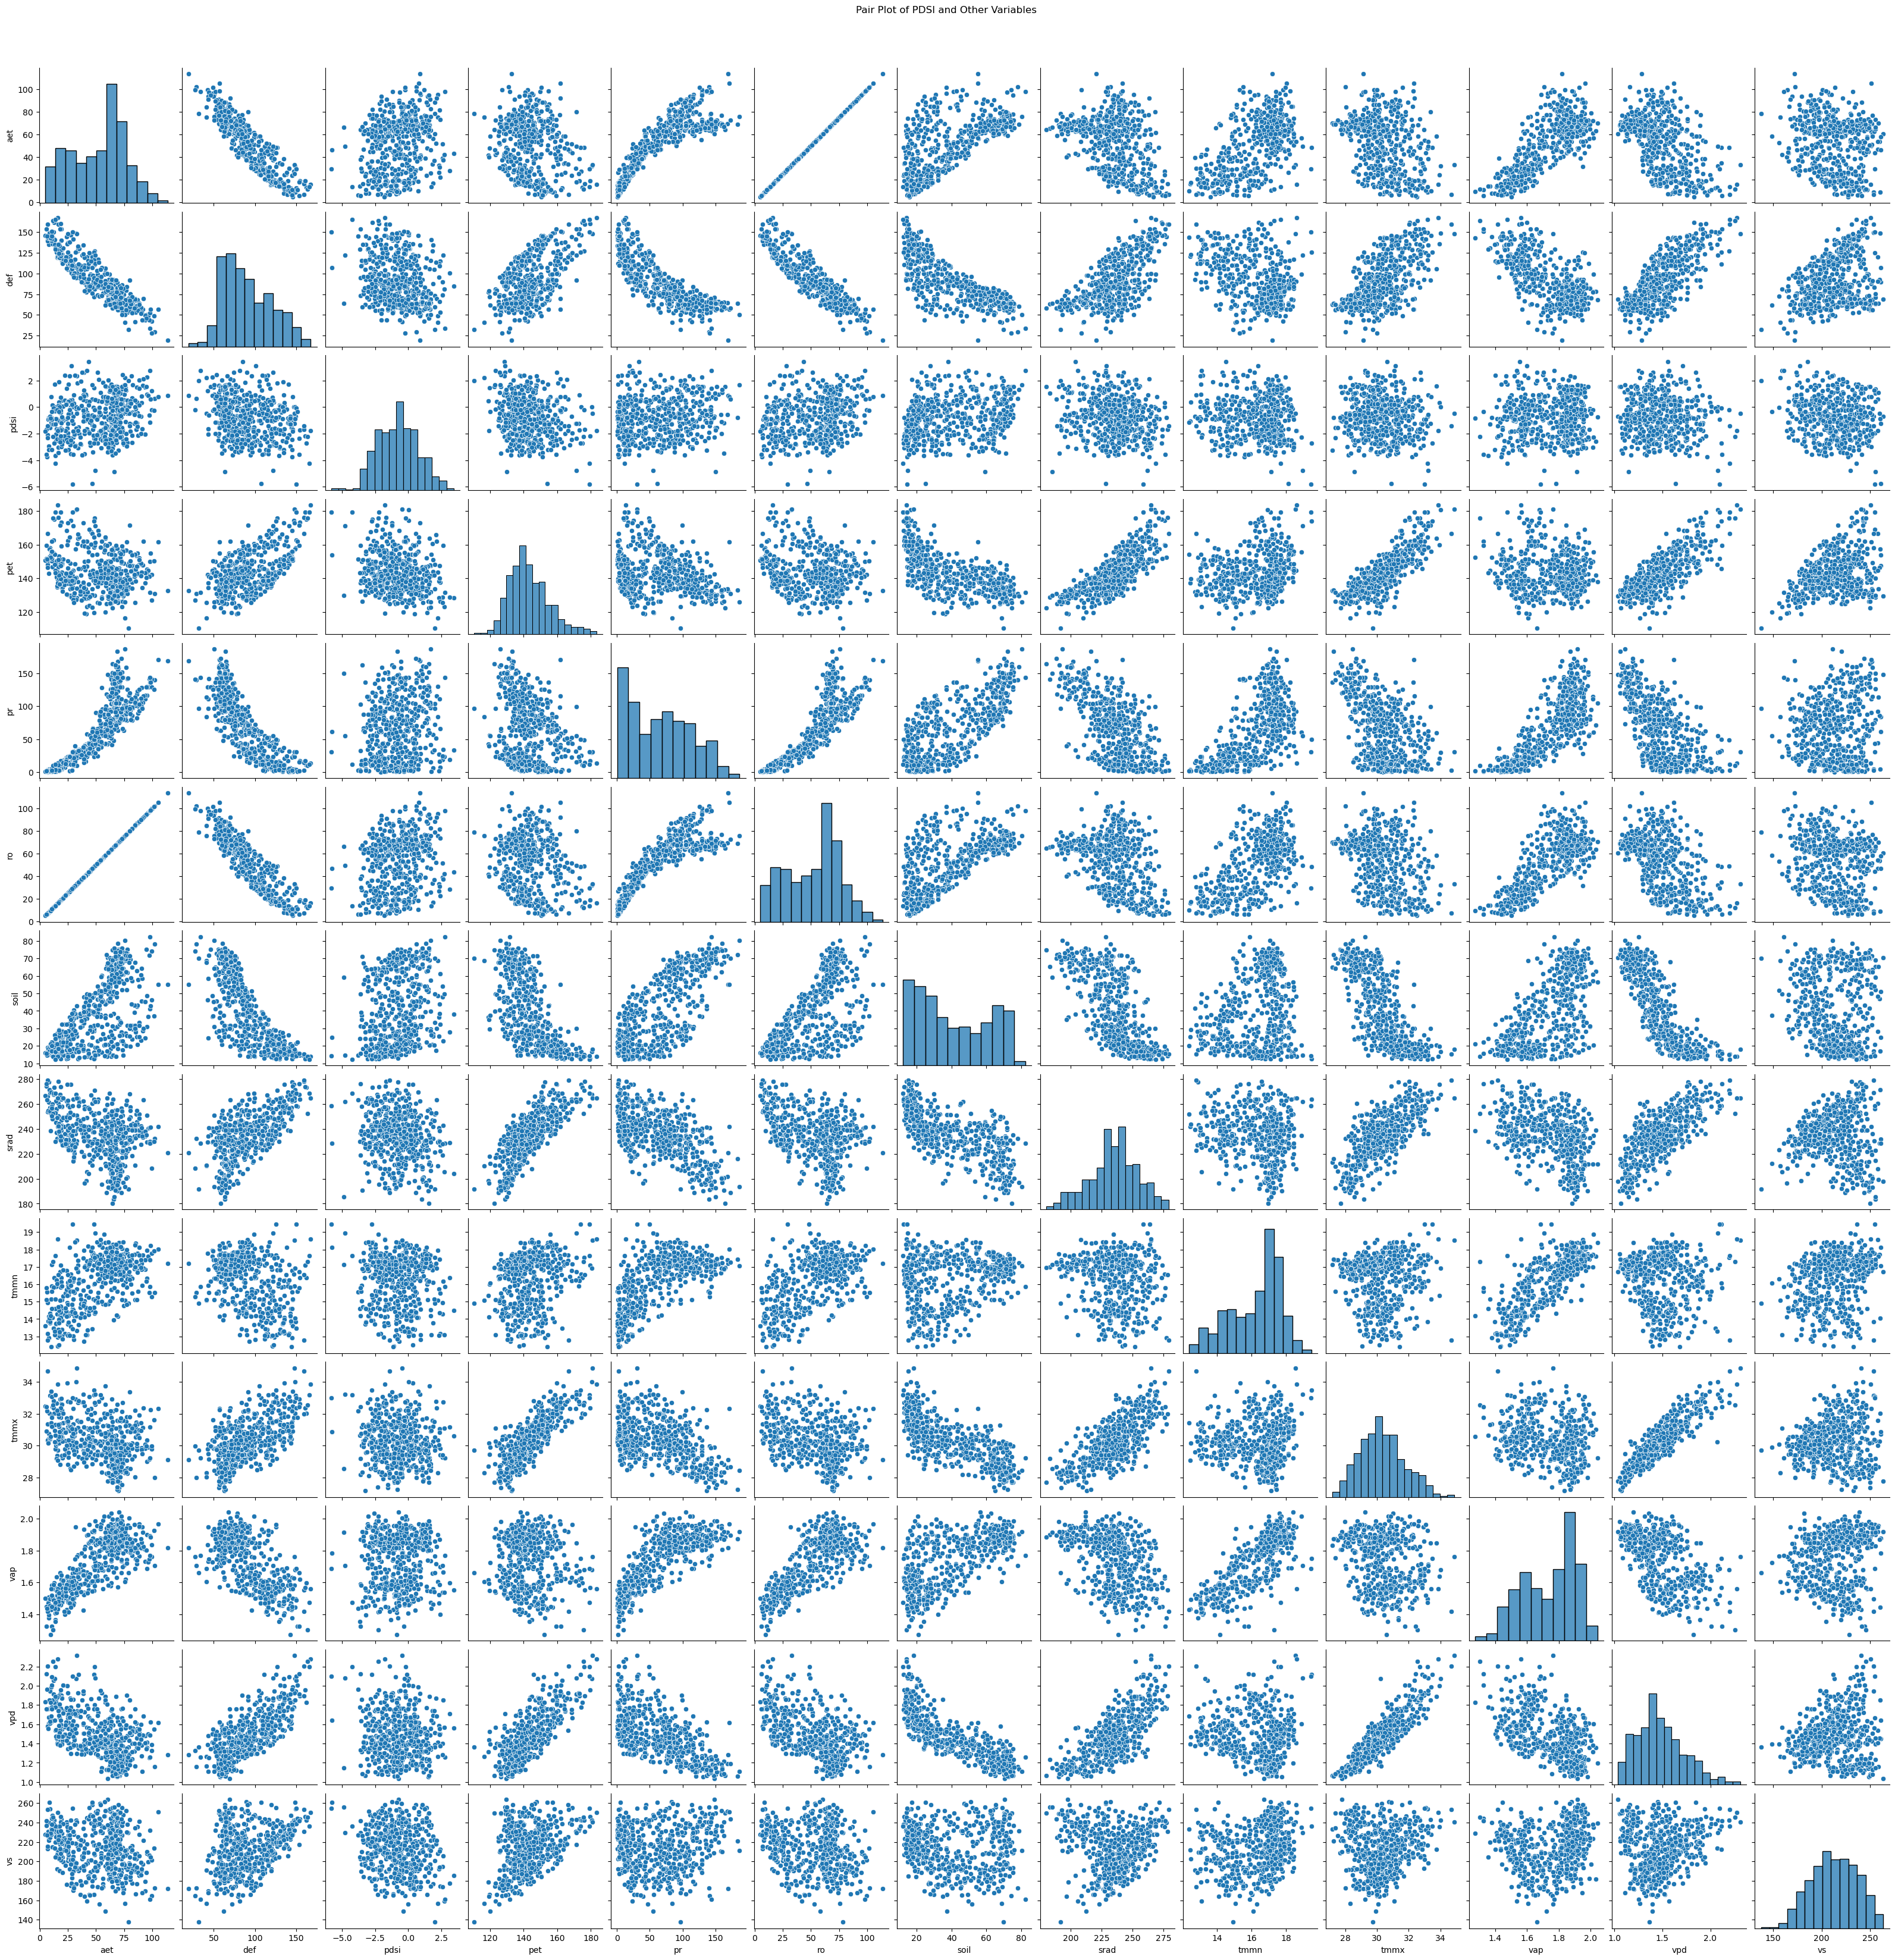

In [117]:

# 1. Visualize Relationships

# Scatter plot matrix (Pair Plot)
sns.pairplot(df_cleaned)
plt.suptitle('Pair Plot of PDSI and Other Variables', y=1.02)
plt.show()

# Correlation heatmap

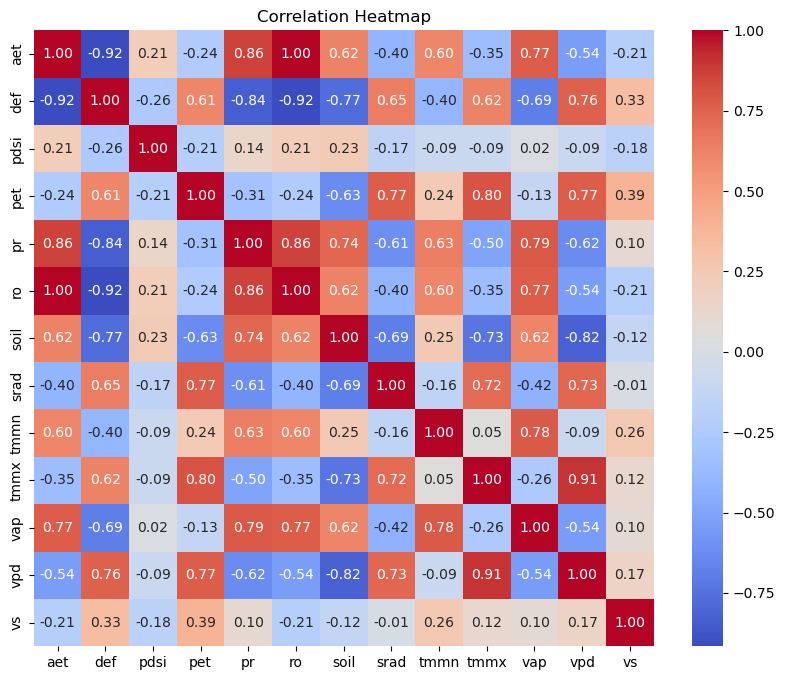

In [118]:

corr = df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

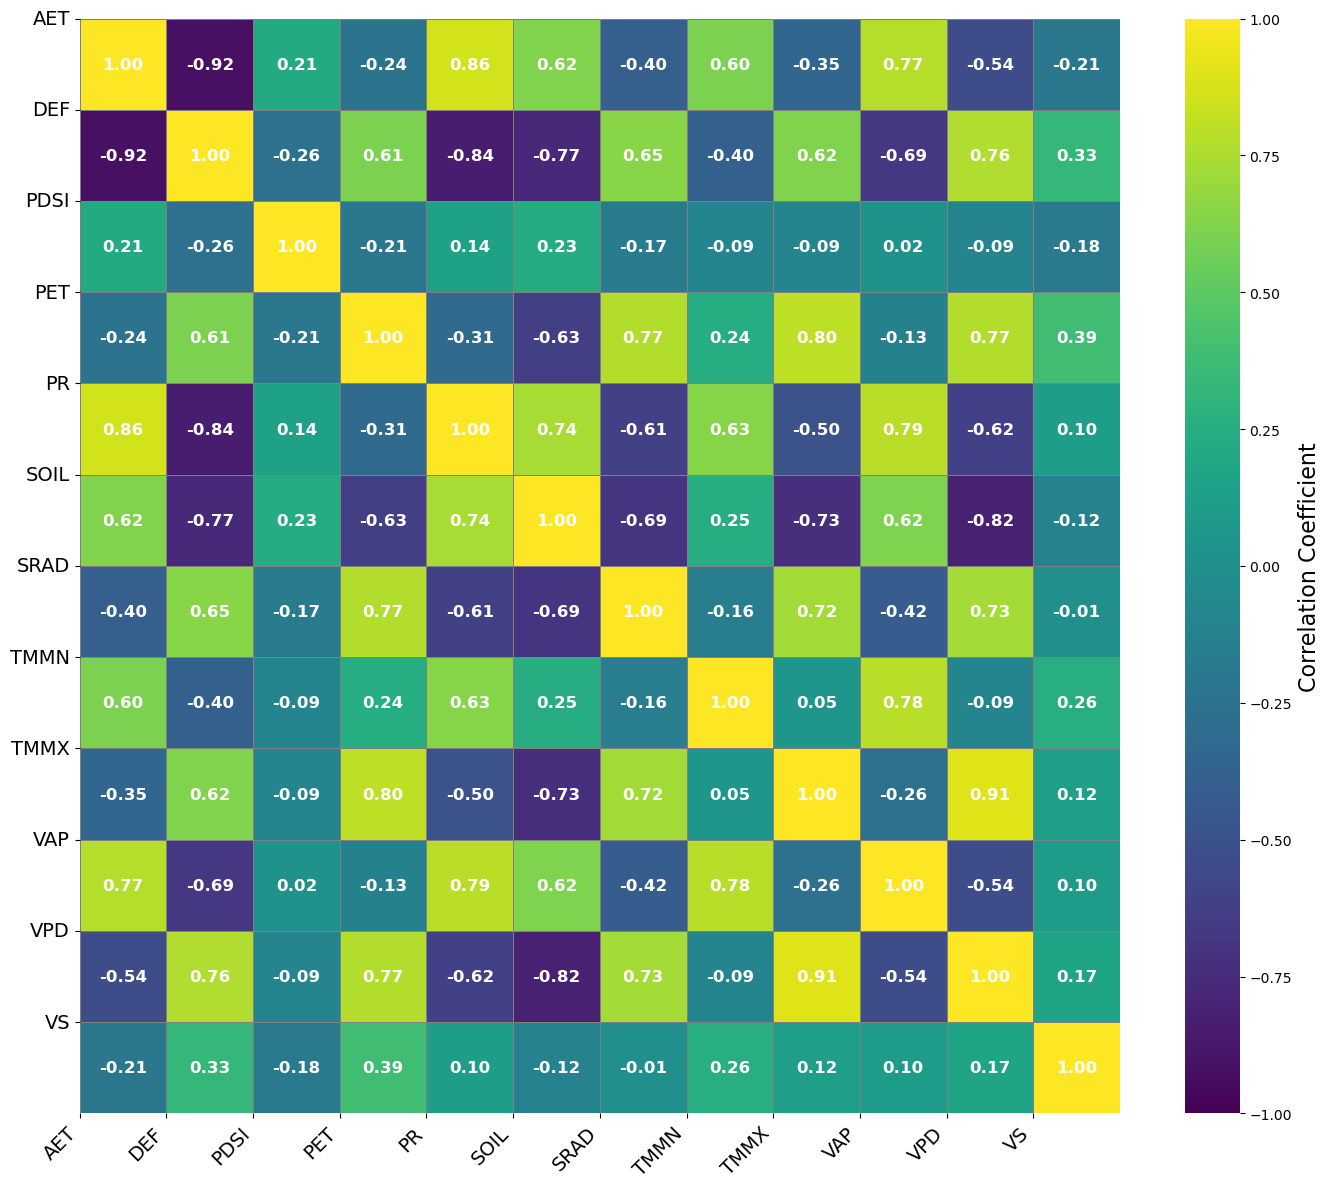

In [128]:

corr_matrix = df_cleaned.corr()

plt.figure(figsize=(14, 12))

# Enhanced heatmap with improved styling and uppercase variables
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1,
            annot_kws={'size': 12, 'weight': 'bold', 'color': 'white'}, linewidths=0.5, linecolor='grey')

# Add a color bar with a label
colorbar = plt.gca().collections[0].colorbar
colorbar.set_label('Correlation Coefficient', fontsize=16)

# Titles and labels
#plt.title('Correlation Matrix of TERRACLIMATE VARIABLES', fontsize=22, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# Apply uppercase to x and y ticks
plt.xticks(ticks=range(len(corr_matrix.columns)), labels=[label.upper() for label in corr_matrix.columns], fontsize=14)
plt.yticks(ticks=range(len(corr_matrix.columns)), labels=[label.upper() for label in corr_matrix.columns], fontsize=14)

plt.tight_layout()

# Save and show the plot
plt.savefig('Enhanced_Correlation_Matrix_TerraClimate_Updated.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:

# 2. Check for Multicollinearity (VIF)
df_cleaned = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
       'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude','swe','ro'])
# Standardize the variables for VIF calculation
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(df_scaled, i) for i in range(df_scaled.shape[1])]

print(vif_data)




   Variable           VIF
0       aet  2.430821e+09
1       def  3.627141e+09
2      pdsi  1.309735e+00
3       pet  6.179447e+08
4        pr  1.355337e+01
5      soil  5.250980e+00
6      srad  5.906911e+00
7      tmmn  8.954595e+00
8      tmmx  2.073431e+01
9       vap  1.985740e+01
10      vpd  3.278236e+01
11       vs  3.191392e+00


In [215]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

# Load and prepare the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df_cleaned = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                              'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'ro','Date'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned.drop(columns=['pdsi']))  # Exclude the target variable from scaling

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Prepare the target variable
y = df_cleaned['pdsi'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define and tune models
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print("Best Ridge Params:", ridge_grid.best_params_)

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 0.5, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print("Best Lasso Params:", lasso_grid.best_params_)

# Decision Tree
decision_tree = DecisionTreeRegressor()
tree_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='neg_mean_squared_error')
tree_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", tree_grid.best_params_)

# Random Forest
random_forest = RandomForestRegressor()
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

# Gradient Boosting
grad_boosting = GradientBoostingRegressor()
gb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(grad_boosting, gb_params, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

# SVR
svr = SVR()
svr_params = {'C': [10, 50, 100, 200], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)
print("Best SVR Params:", svr_grid.best_params_)

# Evaluate models
models = {
    'Ridge Regression': ridge_grid.best_estimator_,
    'Lasso Regression': lasso_grid.best_estimator_,
    'Decision Tree': tree_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Gradient Boosting': gb_grid.best_estimator_,
    'SVR': svr_grid.best_estimator_,
    'AdaBoost': AdaBoostRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Cross-Validation for Ensemble Models
kf = KFold(n_splits=5)
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_cv_mse = -np.mean(cv_scores)
    print(f"{name} - Mean CV MSE: {mean_cv_mse}")

    # R² and Adjusted R²
    r2_scores = []
    adjusted_r2_scores = []
    for train_idx, test_idx in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        
        r2 = r2_score(y_test_fold, y_pred_fold)
        adjusted_r2 = 1 - (1 - r2) * (len(y_test_fold) - 1) / (len(y_test_fold) - X_test_fold.shape[1] - 1)
        
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)
    
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    print(f"{name} - Mean R²: {mean_r2}, Mean Adjusted R²: {mean_adjusted_r2}")


Best Ridge Params: {'alpha': 10}
Best Lasso Params: {'alpha': 0.1}
Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 10}
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Gradient Boosting Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best SVR Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Ridge Regression - MSE: 2.1570886738246773, R²: 0.1656038982687421
Lasso Regression - MSE: 2.2809622003766457, R²: 0.11768765406566928
Decision Tree - MSE: 2.295508167644699, R²: 0.11206104328621802
Random Forest - MSE: 2.1888267223456017, R²: 0.153327117863854
Gradient Boosting - MSE: 2.309754235641137, R²: 0.10655043830021615
SVR - MSE: 2.20337610593584, R²: 0.1476991855968125
AdaBoost - MSE: 2.4666594582057377, R²: 0.0458570103304492
XGBoost - MSE: 2.342198679986963, R²: 0.09400041278967741
Ridge Regression - Mean CV MSE: 2.068169629524337
Ridge Regression - Mean R²: 0.0774392827156779, Mean Adjusted R²: 0.0170

In [216]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# Load the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Define features and target
features = ['aet', 'def', 'pet', 'pr', 'ro', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (optional, if required by the model)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train_scaled)
X_poly_test = poly.transform(X_test_scaled)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Keeps 95% of variance
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

# Feature Selection with RFE
model_rfe = Ridge()  # Example with Ridge, you can use any other model
rfe = RFE(model_rfe, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)
selected_features = [f for f, s in zip(features, rfe.support_) if s]

# Train and evaluate models

def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Models to compare
models = {
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=3, min_samples_split=10),
    'Random Forest': RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200),
    'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100),
    'SVR': SVR(C=10, gamma=0.001, kernel='rbf')
}

# Evaluate on original scaled features
print("Evaluation on Scaled Features:")
for name, model in models.items():
    mse, r2 = train_and_evaluate(model, X_train_scaled, X_test_scaled, y_train, y_test)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Evaluate on polynomial features
print("\nEvaluation on Polynomial Features:")
for name, model in models.items():
    mse, r2 = train_and_evaluate(model, X_poly_train, X_poly_test, y_train, y_test)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Evaluate on PCA-reduced features
print("\nEvaluation on PCA Features:")
for name, model in models.items():
    mse, r2 = train_and_evaluate(model, X_pca_train, X_pca_test, y_train, y_test)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Evaluate on selected features (using RFE)
X_selected_train = rfe.transform(X_train_scaled)
X_selected_test = rfe.transform(X_test_scaled)
print("\nEvaluation on Selected Features:")
for name, model in models.items():
    mse, r2 = train_and_evaluate(model, X_selected_train, X_selected_test, y_train, y_test)
    print(f"{name} - MSE: {mse}, R²: {r2}")


Evaluation on Scaled Features:
Ridge Regression - MSE: 1.8213144897064864, R²: 0.29548667670522266
Lasso Regression - MSE: 2.3258959574896063, R²: 0.10030656434685092
Decision Tree - MSE: 2.4807226170485004, R²: 0.04041715750528785
Random Forest - MSE: 1.863129979826963, R²: 0.279311782102191
Gradient Boosting - MSE: 2.2714857751797926, R²: 0.12135328558956127
SVR - MSE: 1.9283928138249509, R²: 0.2540670831073636

Evaluation on Polynomial Features:
Ridge Regression - MSE: 1.7621081882533138, R²: 0.31838861287962217
Lasso Regression - MSE: 2.339634249849538, R²: 0.09499237502831614
Decision Tree - MSE: 2.1113066509371445, R²: 0.18331311063922695
Random Forest - MSE: 1.863095293435771, R²: 0.2793251993482898
Gradient Boosting - MSE: 2.2179783792588847, R²: 0.1420507947425046
SVR - MSE: 1.940830681800856, R²: 0.24925591856003781

Evaluation on PCA Features:
Ridge Regression - MSE: 2.1686587291445503, R²: 0.1611284174167661
Lasso Regression - MSE: 2.248237408807009, R²: 0.13034612232755027

In [218]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search_rf.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Random Forest Params:", grid_search_rf.best_params_)
print("Best Random Forest MSE:", -grid_search_rf.best_score_)



C:\Users\LEBELA TADELE MELESE\anaconda3\envs\ee\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
244 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LEBELA TADELE MELESE\anaconda3\envs\ee\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LEBELA TADELE MELESE\anaconda3\envs\ee\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\LEBELA TADELE MELESE\anaconda3\envs\ee\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best Random Forest Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest MSE: 1.8325982600821376


In [219]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_gb = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GradientBoostingRegressor
gb = GradientBoostingRegressor()

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search_gb.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Gradient Boosting Params:", grid_search_gb.best_params_)
print("Best Gradient Boosting MSE:", -grid_search_gb.best_score_)


C:\Users\LEBELA TADELE MELESE\anaconda3\envs\ee\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best Gradient Boosting MSE: 1.8049534219066232


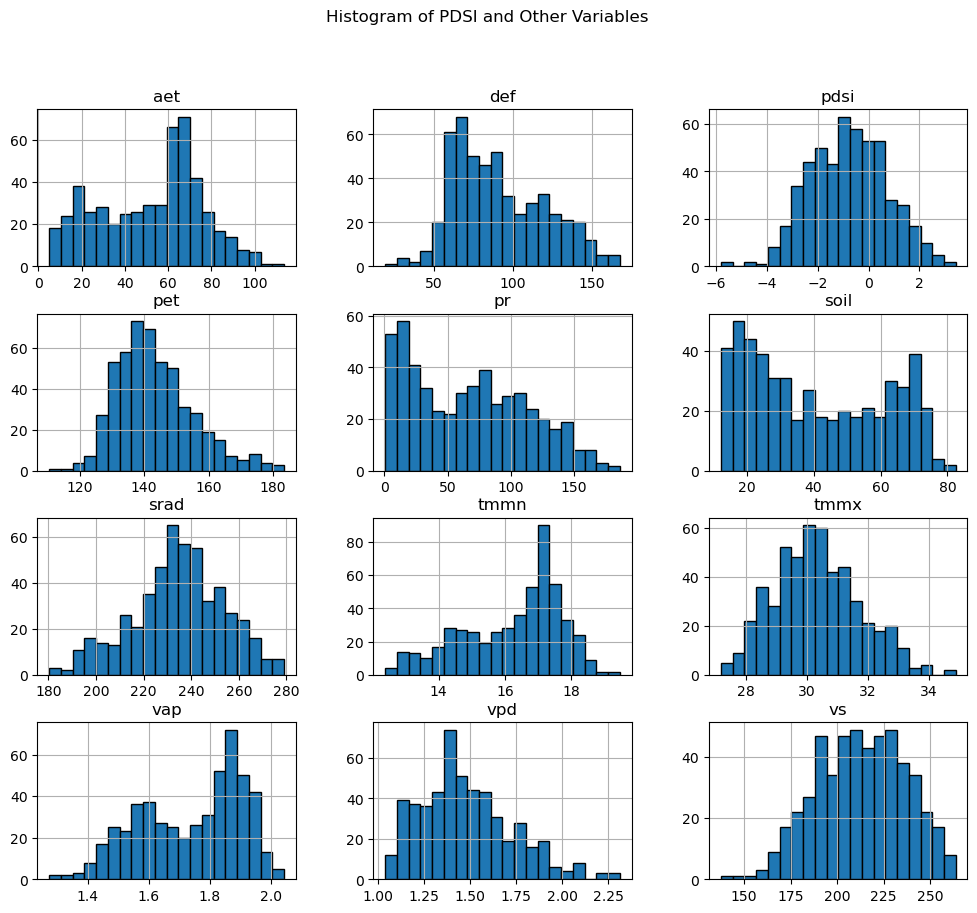

In [123]:
# 3. Distribution Analysis

# Histograms
df_cleaned.hist(figsize=(12, 10), bins=20, edgecolor='k')
plt.suptitle('Histogram of PDSI and Other Variables')
plt.show()





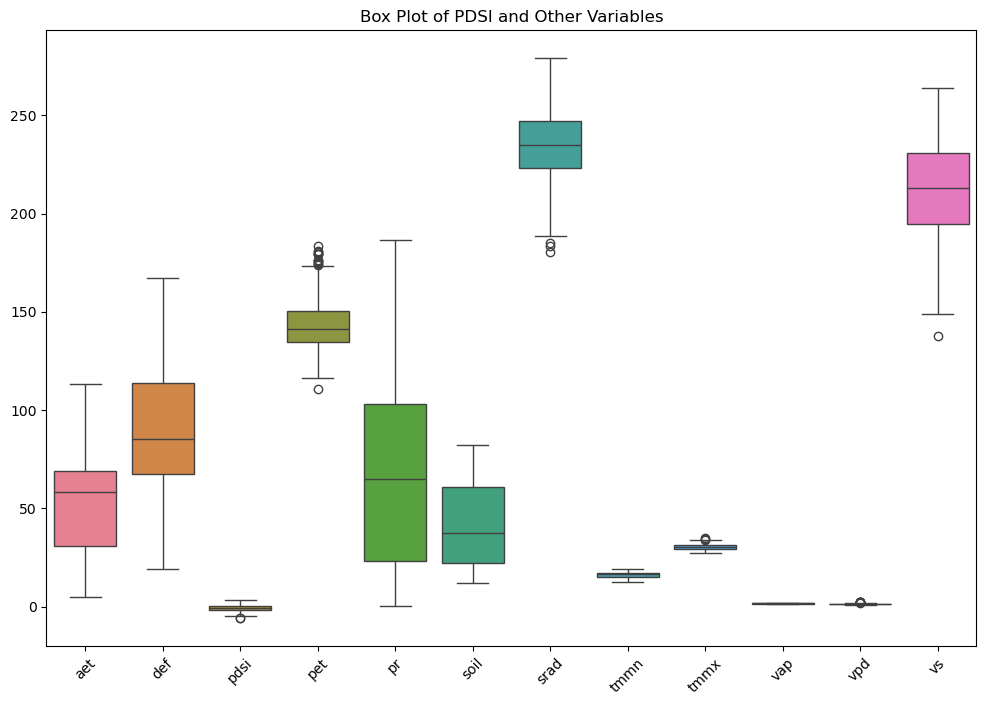

In [126]:
# Box plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned)
plt.title('Box Plot of PDSI and Other Variables')
plt.xticks(rotation=45)
plt.show()

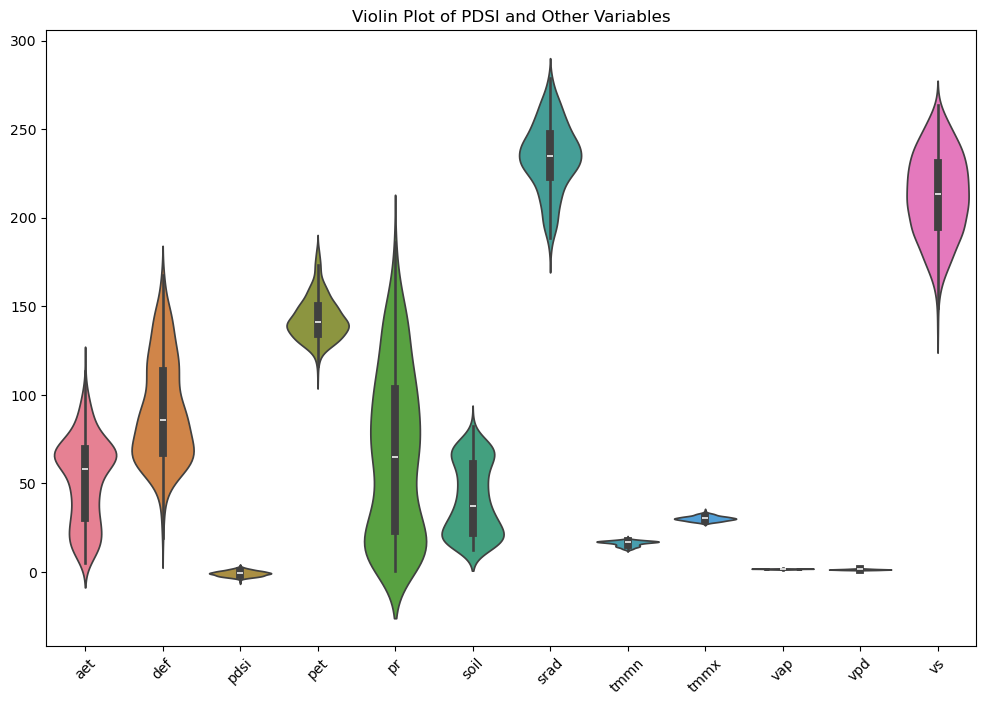

In [127]:
# Violin plots
plt.figure(figsize=(12, 8))
sns.violinplot(data=df_cleaned)
plt.title('Violin Plot of PDSI and Other Variables')
plt.xticks(rotation=45)
plt.show()

# Time series Analysis

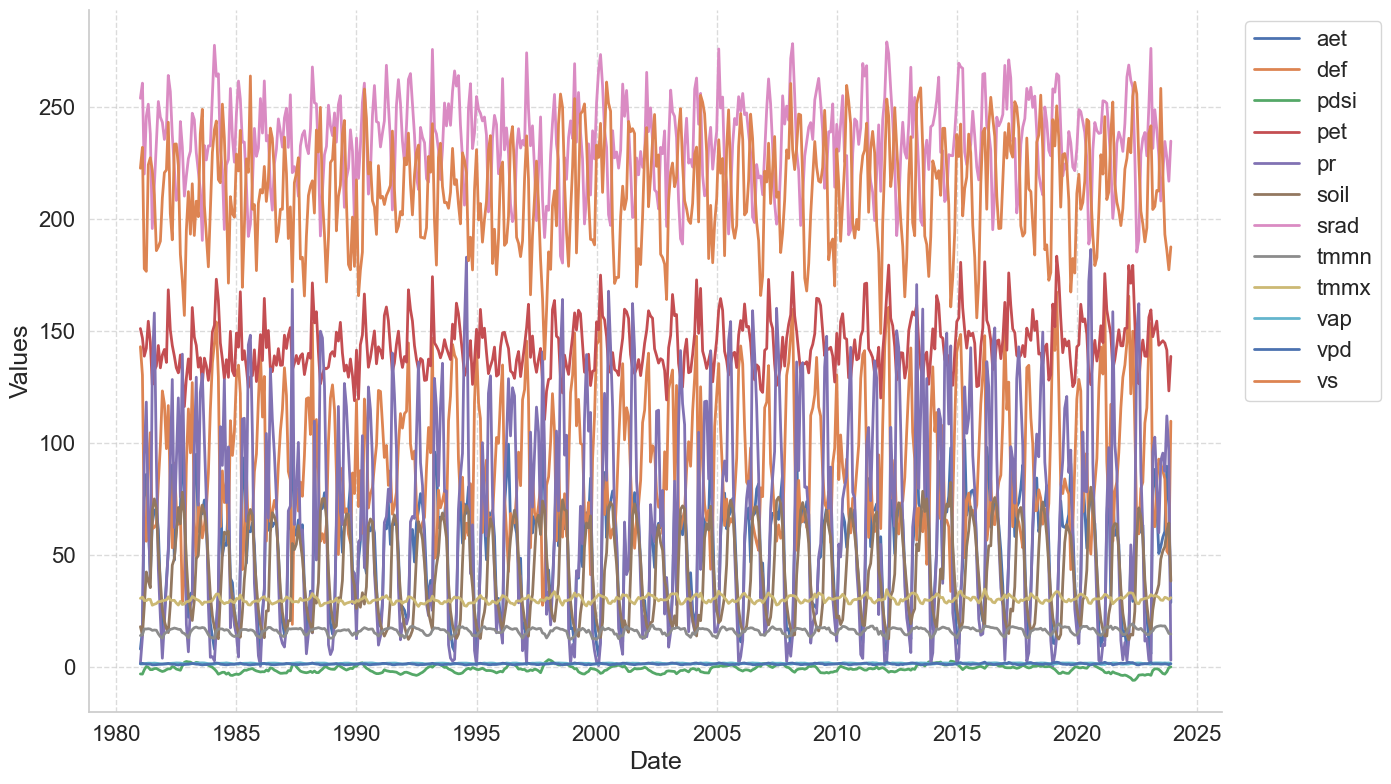

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df.dropna(inplace=True)



# Time Series Analysis
df_time_series = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
       'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude','swe', 'ro'])

df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot each variable
for column in df_time_series.columns:
    if column != 'Date':
        plt.plot(df_time_series['Date'], df_time_series[column], label=column, linewidth=2)

# Customize the plot
#plt.title('Time Series Analysis of TerraClimate Variables', fontsize=24, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.15, 1))

# Remove the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Save the figure with proper settings
plt.tight_layout()
plt.savefig('Time_Series_Analysis.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Time series data for variables using Standardization

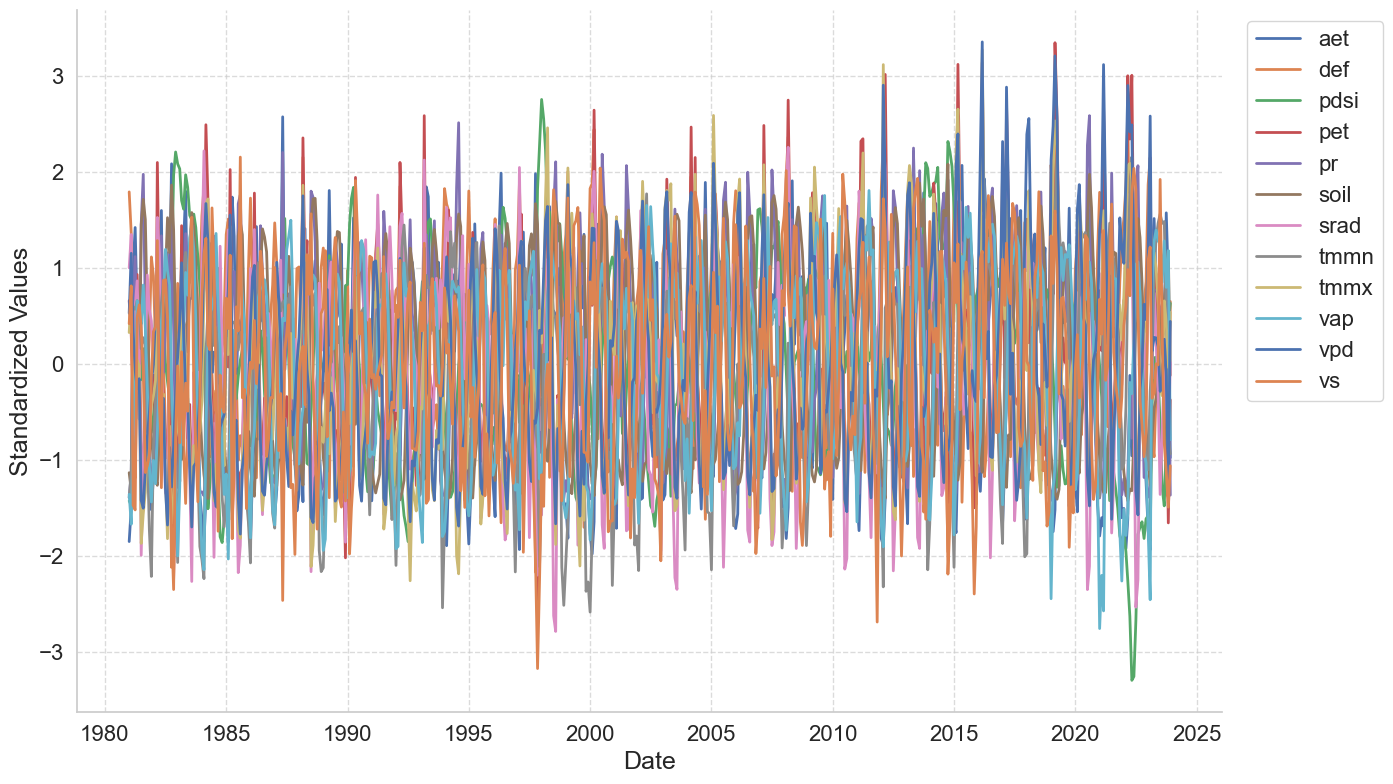

In [168]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df.dropna(inplace=True)

# Prepare the time series data
df_time_series = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                                   'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude','swe', 'ro'])
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])

# Standardize the variables
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_time_series.drop(columns=['Date'])), 
                               columns=df_time_series.columns[1:], 
                               index=df_time_series.index)
df_standardized['Date'] = df_time_series['Date']

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot each standardized variable
for column in df_standardized.columns:
    if column != 'Date':
        plt.plot(df_standardized['Date'], df_standardized[column], label=column, linewidth=2)

# Customize the plot
plt.xlabel('Date', fontsize=18)
plt.ylabel('Standardized Values', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.15, 1))

# Remove the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Save the figure with proper settings
plt.tight_layout()
plt.savefig('Time_Series_Analysis_Standardized.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Plotting PDF and CDF

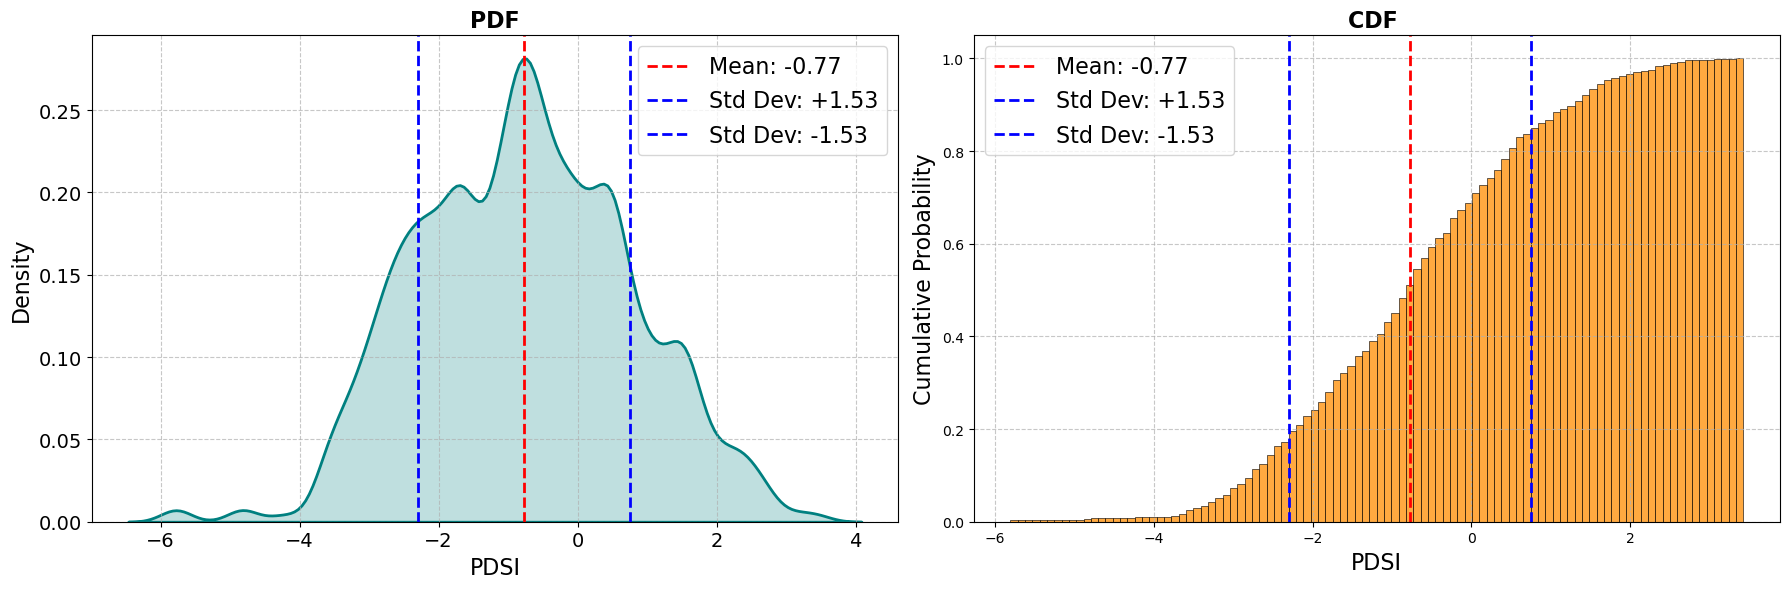

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Choose a variable for analysis
variable = 'pdsi'  # Replace with the variable you want to analyze

# Drop missing values for the selected variable
data = df[variable].dropna()

# Calculate the mean and standard deviation
mean = np.mean(data)
std_dev = np.std(data)

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot PDF on the first subplot
sns.kdeplot(data, bw_adjust=0.5, fill=True, ax=axes[0], color="teal", linewidth=2)
axes[0].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
axes[0].axvline(mean + std_dev, color='blue', linestyle='--', linewidth=2, label=f'Std Dev: +{std_dev:.2f}')
axes[0].axvline(mean - std_dev, color='blue', linestyle='--', linewidth=2, label=f'Std Dev: -{std_dev:.2f}')
axes[0].set_title(f'PDF', fontsize=16, fontweight='bold')
axes[0].set_xlabel('PDSI', fontsize=16)
axes[0].set_ylabel('Density', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Increase font size of grid labels
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=16)

# Plot CDF on the second subplot
sns.histplot(data, cumulative=True, stat='density', kde=False, bins=100, ax=axes[1], color="darkorange", edgecolor="black")
axes[1].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
axes[1].axvline(mean + std_dev, color='blue', linestyle='--', linewidth=2, label=f'Std Dev: +{std_dev:.2f}')
axes[1].axvline(mean - std_dev, color='blue', linestyle='--', linewidth=2, label=f'Std Dev: -{std_dev:.2f}')
axes[1].set_title(f'CDF ', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PDSI', fontsize=16)
axes[1].set_ylabel('Cumulative Probability', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Increase font size of grid labels
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=16)

# Enhance layout and show the plots
plt.tight_layout()
plt.savefig('PDF_CDF of PDSI .png', dpi=300, bbox_inches='tight')
plt.show()

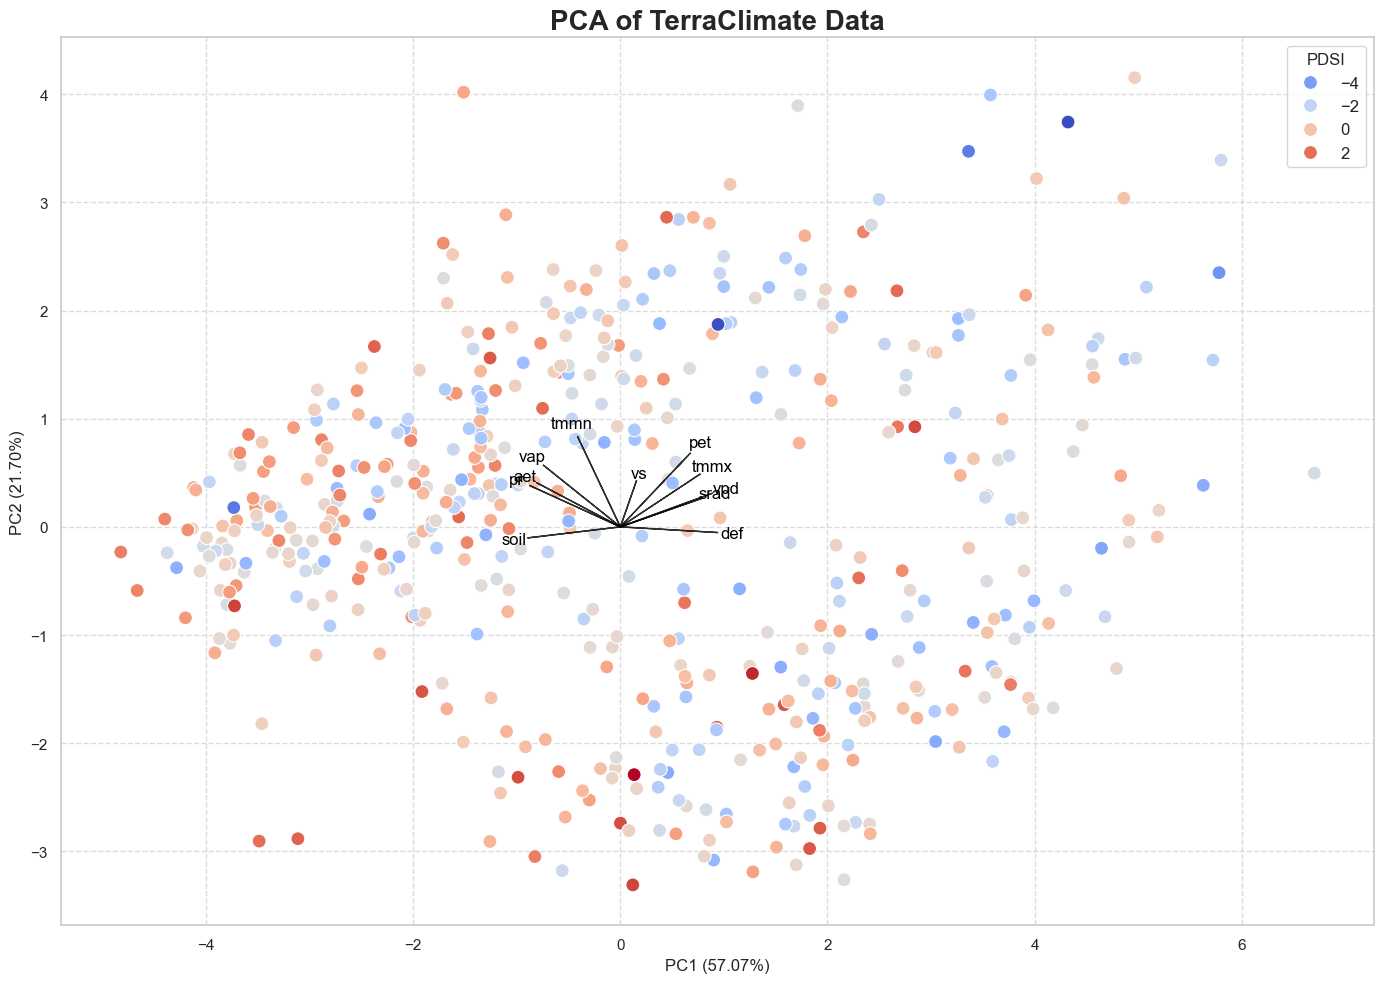

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Standardize the data
features = ['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']  # Corrected to a list
x = df[features].values
y = df['pdsi'].values  # Target variable

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['PDSI'] = y

# Plotting
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create the scatter plot with PDSI as the hue
sns.scatterplot(x='PC1', y='PC2', hue='PDSI', data=pca_df, s=100, palette='coolwarm', alpha=1, edgecolor="w")

# Add percentage of variance explained to the axes
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

# Add arrows and text for loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='black', alpha=0.8)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, color='black', ha='center', va='center', fontsize=12)

# Add grid, title, and improve layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('PCA of TerraClimate Data', fontsize=20, fontweight='bold')
plt.legend(title='PDSI', loc='upper right', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('PCA_Plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



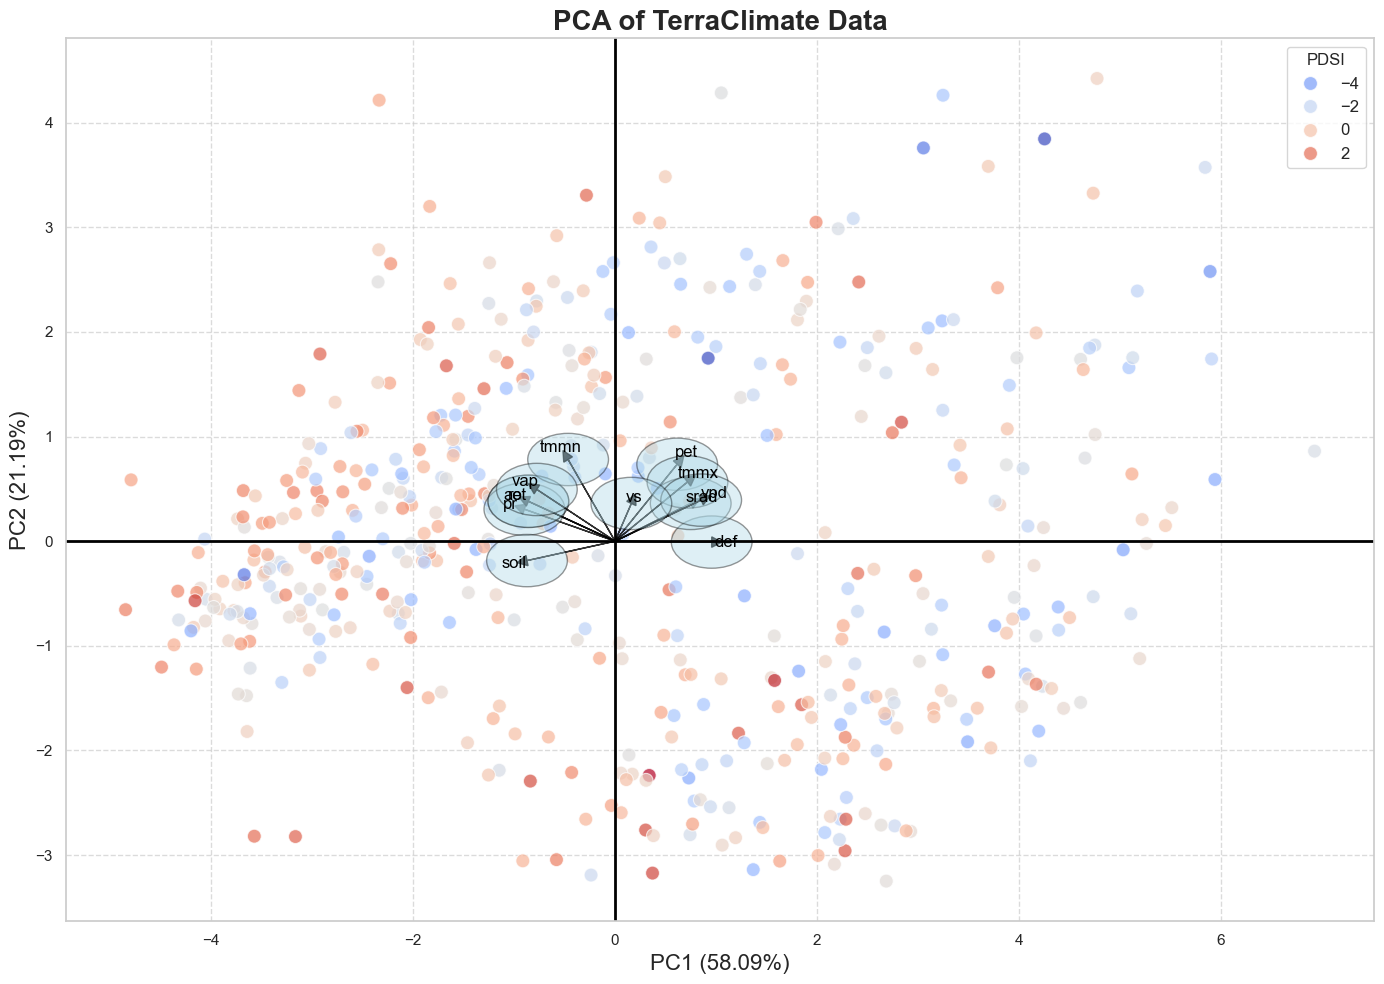

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# Load your data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index','ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Standardize the data
features = ['aet', 'def', 'pet', 'pr', 'ro', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']  # Corrected to a list
x = df[features].values
y = df['pdsi'].values  # Target variable

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['PDSI'] = y

# Plotting
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create the scatter plot with PDSI as the hue
sns.scatterplot(x='PC1', y='PC2', hue='PDSI', data=pca_df, s=100, palette='coolwarm', alpha=0.7, edgecolor="w")

# Add percentage of variance explained to the axes
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=16)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=16)

# Draw bold horizontal and vertical lines
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)

# Add arrows and text for loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='black', alpha=0.8, head_width=0.1, head_length=0.1)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, color='black', ha='center', va='center', fontsize=12)

    # Encircle each variable with an ellipse
    ellipse = Ellipse((loadings[i, 0], loadings[i, 1]), width=0.8, height=0.5, edgecolor='black', fc='lightblue', alpha=0.4)
    plt.gca().add_patch(ellipse)

# Add grid, title, and improve layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('PCA of TerraClimate Data', fontsize=20, fontweight='bold')
plt.legend(title='PDSI', loc='upper right', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('PCA_Plot_Enhanced.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
## Handling outlier

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_17076\1321735826.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Value', data=df_long, palette='viridis')


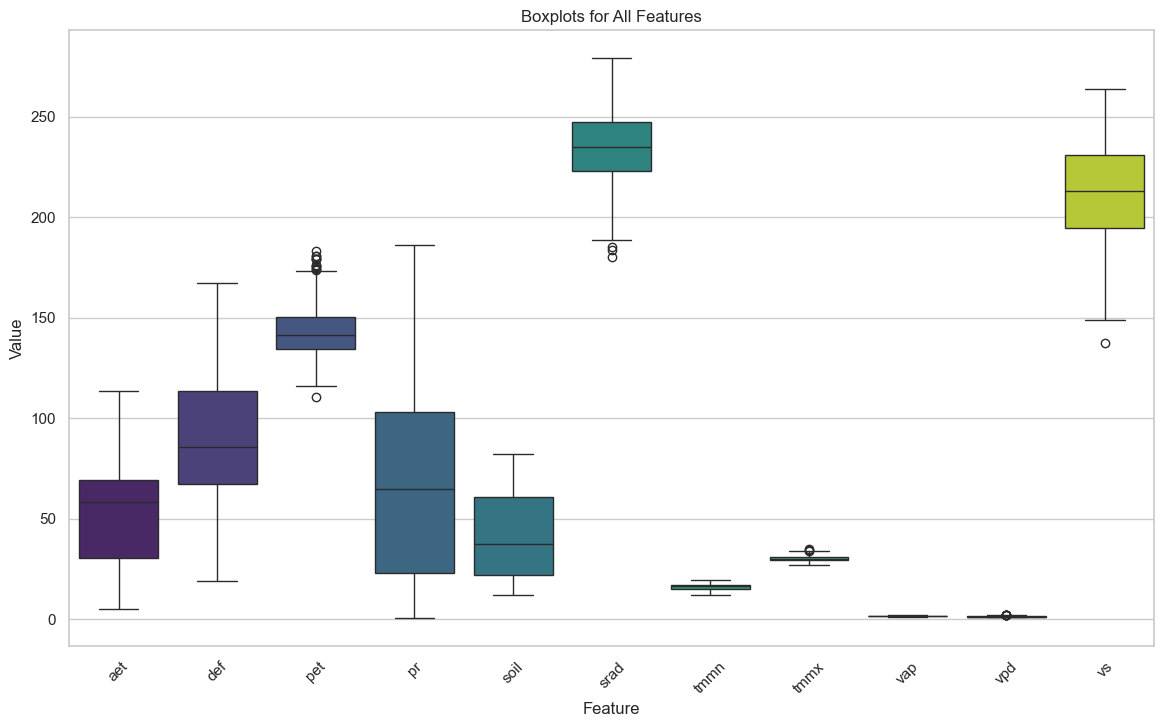

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Standardize the data (assuming columns are already standardized)
features = ['aet', 'def', 'pet', 'pr',  'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
target = 'pdsi'

# Reshape the DataFrame to long format
df_long = pd.melt(df, id_vars=[target], value_vars=features, var_name='Feature', value_name='Value')

# Create boxplots for all features
plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Value', data=df_long, palette='viridis')
plt.title('Boxplots for All Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()


C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_17076\2158670380.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Value', data=df_long_before, palette='viridis', ax=axes[0])
C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_17076\2158670380.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Value', data=df_long_after, palette='viridis', ax=axes[1])


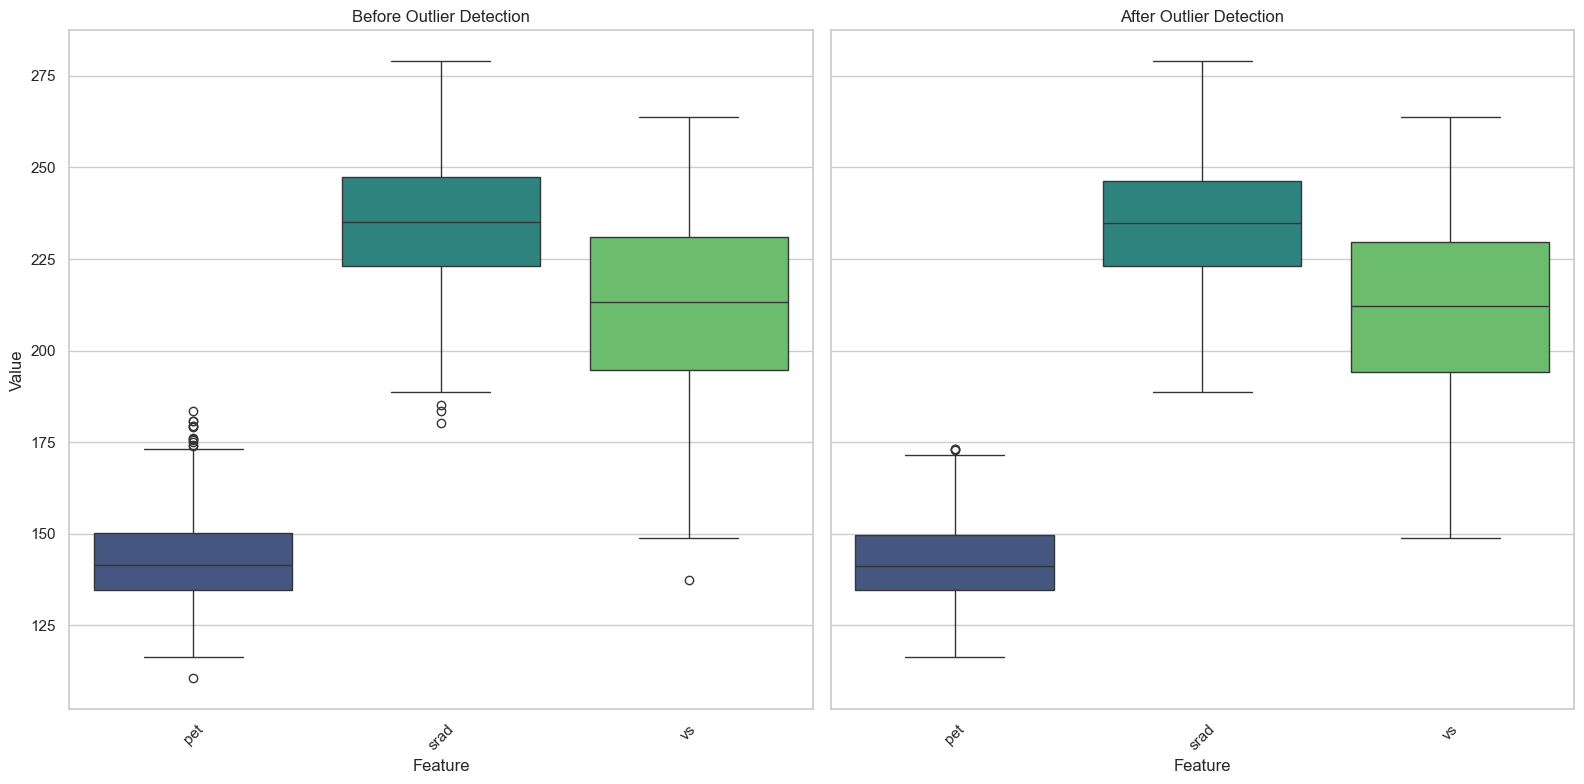

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Define function to detect and remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Handle outliers for specified columns
columns_to_check = ['pet', 'srad', 'vs']
df_no_outliers = df.copy()

for column in columns_to_check:
    df_no_outliers = remove_outliers(df_no_outliers, column)

# Reshape the DataFrames to long format
df_long_before = pd.melt(df, value_vars=columns_to_check, var_name='Feature', value_name='Value')
df_long_after = pd.melt(df_no_outliers, value_vars=columns_to_check, var_name='Feature', value_name='Value')

# Plot before and after outlier detection side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot before outlier removal
sns.boxplot(x='Feature', y='Value', data=df_long_before, palette='viridis', ax=axes[0])
axes[0].set_title('Before Outlier Detection')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
axes[0].tick_params(axis='x', rotation=45)

# Plot after outlier removal
sns.boxplot(x='Feature', y='Value', data=df_long_after, palette='viridis', ax=axes[1])
axes[1].set_title('After Outlier Detection')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Value')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Train test Split 

In [170]:
from sklearn.model_selection import train_test_split
# Load your data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
# Drop unwanted columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', ,'ro', 'Date'])
# Define features and target
features = ['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
target = 'pdsi'

# Prepare features and target arrays
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardization

In [173]:
from sklearn.preprocessing import StandardScaler
# Initializing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose and Train Machine Learning Models

In [174]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Define function to calculate Adjusted R-squared
def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


# Initialize and train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

results = {}
n = X_test_scaled.shape[0]  # Number of observations
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    p = X_test_scaled.shape[1]  # Number of predictors
    adj_r2 = adjusted_r2_score(r2, n, p)
    results[name] = {'MSE': mse, 'R2': r2, 'Adjusted R2': adj_r2}

# Create a DataFrame to show results
results_df = pd.DataFrame(results).T
print(results_df)



                        MSE        R2  Adjusted R2
Linear Regression  1.765105  0.317229     0.235594
Ridge Regression   1.787023  0.308751     0.226102
Lasso Regression   2.592356 -0.002764    -0.122660
Decision Tree      3.680336 -0.423612    -0.593827
Random Forest      1.882163  0.271949     0.184900
Gradient Boosting  1.914079  0.259604     0.171078
SVR                1.910677  0.260920     0.172552


# Hyperparameter Tuning with GridSearchCV

In [177]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['linear', 'rbf']
    }
}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Initialize results dictionary
results = {}

# Perform Grid Search for each model
for name, model in models.items():
    param_grid = param_grids[name]
    if param_grid:  # Skip if there are no parameters to tune
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        p = X_test_scaled.shape[1]
        adj_r2 = adjusted_r2_score(r2, n, p)
        results[name] = {
            'Best Params': best_params,
            'MSE': mse,
            'R2': r2,
            'Adjusted R2': adj_r2
        }

# Create a DataFrame to show results
results_df = pd.DataFrame(results).T
print(results_df)


                                                         Best Params  \
Ridge Regression                                       {'alpha': 10}   
Lasso Regression                                      {'alpha': 0.1}   
Decision Tree             {'max_depth': 10, 'min_samples_split': 10}   
Random Forest      {'max_depth': 20, 'min_samples_split': 10, 'n_...   
Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
SVR                       {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}   

                        MSE        R2 Adjusted R2  
Ridge Regression   1.825115  0.294017    0.209606  
Lasso Regression   2.325896  0.100307   -0.007265  
Decision Tree      2.918679 -0.128992    -0.26398  
Random Forest      1.861355  0.279998    0.193911  
Gradient Boosting   1.91375  0.259731    0.171221  
SVR                1.735456  0.328698    0.248434  


Your hyperparameter tuning results indicate the performance of various models on your dataset. Here's a summary:

- **Ridge Regression** performed relatively well with an Adjusted R² of 0.21, meaning it captures some of the variance in PDSI.
- **Lasso Regression** and **Decision Tree** did not perform as well, with negative Adjusted R² values, indicating they are not suitable for this dataset in their current configurations.
- **Random Forest** and **Gradient Boosting** models performed similarly, with Adjusted R² values around 0.19 and 0.17, respectively.
- **SVR** showed the best performance with an Adjusted R² of 0.25, suggesting it might be the most suitable model among those tested.

### Next Steps:

1. **Model Selection**: Given that SVR performed the best, you might consider focusing on this model for further refinement or predictions.

2. **Model Interpretation**: Consider interpreting the best model (SVR) to understand which features are most important. This could involve feature importance analysis or partial dependence plots.

3. **Validation**: Perform further validation on the selected model, such as cross-validation, to ensure its robustness.

4. **Prediction**: Use the best model to predict PDSI values on unseen data or for forecasting future trends.

5. **Manuscript Preparation**: Document these findings and decisions in your manuscript, discussing the implications of model performance and your rationale for selecting the best model.



# Step-by-Step Cross-Validation with SVR

- To perform further validation on your selected model (in this case, SVR), cross-validation is a reliable method to assess its robustness. 
- Cross-validation helps to ensure that the model's performance is consistent across different subsets of the data, reducing the risk of overfitting.

In [179]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import numpy as np


best_svr = SVR(C=100, gamma=0.01, kernel='rbf')

# Assuming X_train_scaled and y_train are your training data
scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the MSE scores
mse_scores = -scores  # Negate because 'neg_mean_squared_error' was used
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")


Mean MSE: 1.7466846722670042
Standard Deviation of MSE: 0.25715812144112854


#### Evaluate R² and Adjusted R² Across Folds: While cross-validation generally focuses on MSE, you can also compute R² and adjusted R² for each fold.


### Explanation:
- Cross-Validation (cross_val_score): The model is trained and evaluated multiple times on different subsets of the data. This helps in understanding the model's performance variability.

- Mean and Standard Deviation of MSE: Provides insight into how consistently the model performs across different folds. A lower standard deviation indicates more consistent performance.

- R² and Adjusted R²: These metrics help in understanding how well the model explains the variance in the data.

### Interpreting the Results:
- Mean MSE: Lower values indicate better model performance.
- Standard Deviation of MSE: Indicates consistency across folds; a lower value is preferable.
- Mean R² and Adjusted R²: Higher values indicate better model fit, with adjusted R² accounting for the number of predictors.
- If the SVR model shows consistent and robust performance across folds, you can confidently use it for your PDSI predictions.

In [198]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score

# Ensure X_train_scaled and y_train are numpy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)

# Initialize the SVR Model with Best Parameters
best_svr = SVR(C=100, gamma=0.01, kernel='rbf')

# Perform Cross-Validation for MSE
scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the MSE scores
mse_scores = -scores  # Negate because 'neg_mean_squared_error' was used
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

# Perform Cross-Validation to Evaluate R² and Adjusted R² Across Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Added shuffle for better randomness
r2_scores = []
adjusted_r2_scores = []

for train_idx, test_idx in kf.split(X_train_scaled):
    # Slicing the numpy arrays directly using indices from KFold
    X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    
    best_svr.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_svr.predict(X_test_fold)
    
    # Calculate R²
    r2 = r2_score(y_test_fold, y_pred_fold)
    
    # Calculate Adjusted R²
    n = len(y_test_fold)
    p = X_test_fold.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)

# Output the results
print(f"Mean R²: {np.mean(r2_scores)}")
print(f"Mean Adjusted R²: {np.mean(adjusted_r2_scores)}")



Mean MSE: 1.7466846722670042
Standard Deviation of MSE: 0.25715812144112854
Mean R²: 0.21692006309908587
Mean Adjusted R²: 0.09460563886985421


# Let's compare the results from the SVR model with the other models you tuned. Here's a summary of the hyperparameter tuning results and performance metrics for each model:

### Hyperparameter Tuning Results and Performance Metrics

| Model                  | Best Parameters                                            | Mean MSE | Standard Deviation of MSE | Mean R²  | Mean Adjusted R² |
|------------------------|------------------------------------------------------------|----------|---------------------------|----------|-------------------|
| **Ridge Regression**   | {'alpha': 10}                                              | 1.825115 | -                         | 0.294017 | 0.209606          |
| **Lasso Regression**   | {'alpha': 0.1}                                             | 2.325896 | -                         | 0.100307 | -0.007265         |
| **Decision Tree**      | {'max_depth': 10, 'min_samples_split': 10}                 | 2.918679 | -                         | -0.128992| -0.263980         |
| **Random Forest**      | {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300} | 1.861355 | -                         | 0.279998 | 0.193911          |
| **Gradient Boosting**  | {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200} | 1.913750 | -                         | 0.259731 | 0.171221          |
| **SVR**                | {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}                 | 1.746685 | 0.257158                  | 0.216920 | 0.094606          |

### Comparison:

- **Ridge Regression:**
  - **MSE:** 1.825115
  - **R²:** 0.294017
  - **Adjusted R²:** 0.209606
  - Ridge Regression has the highest R² and Adjusted R², indicating it might be the best performing model among the ones compared.

- **Lasso Regression:**
  - **MSE:** 2.325896
  - **R²:** 0.100307
  - **Adjusted R²:** -0.007265
  - Lasso Regression has the lowest R² and Adjusted R², indicating poor performance.

- **Decision Tree:**
  - **MSE:** 2.918679
  - **R²:** -0.128992
  - **Adjusted R²:** -0.263980
  - The Decision Tree performs the worst in terms of R² and Adjusted R².

- **Random Forest:**
  - **MSE:** 1.861355
  - **R²:** 0.279998
  - **Adjusted R²:** 0.193911
  - Random Forest has better performance than some models but is not the best.

- **Gradient Boosting:**
  - **MSE:** 1.913750
  - **R²:** 0.259731
  - **Adjusted R²:** 0.171221
  - Gradient Boosting performs well but not as well as Ridge Regression.

- **SVR:**
  - **MSE:** 1.746685
  - **R²:** 0.216920
  - **Adjusted R²:** 0.094606
  - SVR has the lowest MSE, but its R² and Adjusted R² are lower compared to Ridge Regression.

### Conclusion:

- **Best Model Based on Metrics:** Ridge Regression appears to perform the best based on R² and Adjusted R². It has the highest R² value and a good Adjusted R². However, SVR has the lowest MSE, which indicates it has the smallest average error in prediction.

- **Considerations:** While Ridge Regression might be the best in terms of explained variance, SVR has the smallest prediction error. Depending on your priority (explained variance vs. prediction error), you might choose Ridge Regression for better interpretability or SVR for minimal prediction error.

You might also want to perform further hyperparameter tuning or try ensemble methods to potentially improve the performance.

## Further Hyperparameter Tuning
Expand Hyperparameter Search Space:

- SVR: Explore different values for C, gamma, and other kernel options.
- Random Forest: Adjust n_estimators, max_features, and min_samples_leaf.
- Gradient Boosting: Try different learning_rate, n_estimators, and max_depth.
- Use Grid Search or Random Search:

- Grid Search: Exhaustively search through a manually specified set of hyperparameters.
- Random Search: Sample from a specified distribution of hyperparameters.

In [203]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.6/124.9 MB 12.0 MB/s eta 0:00:11
   - -------------------------------------- 3.9/124.9 MB 11.2 MB/s eta 0:00:11
   - -------------------------------------- 6.0/124.9 MB 10.6 MB/s eta 0:00:12
   -- ------------------------------------- 8.1/124.9 MB 10.5 MB/s eta 0:00:12
   --- ------------------------------------ 10.5/124.9 MB 10.7 MB/s eta 0:00:11
   ---- ----------------------------------- 13.4/124.9 MB 11.0 MB/s eta 0:00:11
   ----- ---------------------------------- 16.0/124.9 MB 11.3 MB/s eta 0:00:10
   ------ --------------------------------- 18.9/124.9 MB 11.6 MB/s eta 0:00:10
   ------- -------------------------------- 22.0/124.9 MB 11.9 MB/s eta 0:00:09
   -------- ------------------------------- 25.2/124.9 MB 12.2 MB/s eta 0:00:09
   -------- ------------------------------- 28.0/124.9 MB 12.3 MB/s eta 0:00:08
   --------- ------------------------------ 31.2/124.

In [205]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Load and prepare the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])
features = ['aet', 'def', 'pet', 'pr', 'ro', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define and tune models
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print("Best Ridge Params:", ridge_grid.best_params_)

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 0.5, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print("Best Lasso Params:", lasso_grid.best_params_)

# Decision Tree
decision_tree = DecisionTreeRegressor()
tree_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='neg_mean_squared_error')
tree_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", tree_grid.best_params_)

# Random Forest
random_forest = RandomForestRegressor()
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

# Gradient Boosting
grad_boosting = GradientBoostingRegressor()
gb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(grad_boosting, gb_params, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

# SVR
svr = SVR()
svr_params = {'C': [10, 50, 100, 200], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)
print("Best SVR Params:", svr_grid.best_params_)

# Evaluate models
models = {
    'Ridge Regression': ridge_grid.best_estimator_,
    'Lasso Regression': lasso_grid.best_estimator_,
    'Decision Tree': tree_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Gradient Boosting': gb_grid.best_estimator_,
    'SVR': svr_grid.best_estimator_,
    'AdaBoost': AdaBoostRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Cross-Validation for Ensemble Models
kf = KFold(n_splits=5)
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_cv_mse = -np.mean(cv_scores)
    print(f"{name} - Mean CV MSE: {mean_cv_mse}")

    # R² and Adjusted R²
    r2_scores = []
    adjusted_r2_scores = []
    for train_idx, test_idx in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        
        r2 = r2_score(y_test_fold, y_pred_fold)
        adjusted_r2 = 1 - (1 - r2) * (len(y_test_fold) - 1) / (len(y_test_fold) - X_test_fold.shape[1] - 1)
        
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)
    
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    print(f"{name} - Mean R²: {mean_r2}, Mean Adjusted R²: {mean_adjusted_r2}")


Best Ridge Params: {'alpha': 1}
Best Lasso Params: {'alpha': 0.1}
Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 10}
Best Random Forest Params: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100}
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best SVR Params: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Ridge Regression - MSE: 1.8106044362166829, R²: 0.2996294952131797
Lasso Regression - MSE: 2.1097841038363736, R²: 0.1839020559992398
Decision Tree - MSE: 2.4807226170485004, R²: 0.04041715750528785
Random Forest - MSE: 1.865587494556709, R²: 0.278361176438488
Gradient Boosting - MSE: 1.9125752359188726, R²: 0.260185573044201
SVR - MSE: 1.7370325437269023, R²: 0.3280882697806704
AdaBoost - MSE: 2.2090037174398565, R²: 0.14552233623591748
XGBoost - MSE: 1.938546886959004, R²: 0.2501393266166091
Ridge Regression - Mean CV MSE: 1.968829030753458
Ridge Regression - Mean R²: 0.12032511149994148, Mean Adjusted R²: -0.0

In [212]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Load and prepare the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])
features = ['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and tune models
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print("Best Ridge Params:", ridge_grid.best_params_)

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 0.5, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print("Best Lasso Params:", lasso_grid.best_params_)

# Decision Tree
decision_tree = DecisionTreeRegressor()
tree_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='neg_mean_squared_error')
tree_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", tree_grid.best_params_)

# Random Forest
random_forest = RandomForestRegressor()
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

# Gradient Boosting
grad_boosting = GradientBoostingRegressor()
gb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(grad_boosting, gb_params, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

# SVR
svr = SVR()
svr_params = {'C': [10, 50, 100, 200], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)
print("Best SVR Params:", svr_grid.best_params_)

# Evaluate models
models = {
    'Ridge Regression': ridge_grid.best_estimator_,
    'Lasso Regression': lasso_grid.best_estimator_,
    'Decision Tree': tree_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Gradient Boosting': gb_grid.best_estimator_,
    'SVR': svr_grid.best_estimator_,
    'AdaBoost': AdaBoostRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Cross-Validation for Ensemble Models
kf = KFold(n_splits=5)
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_cv_mse = -np.mean(cv_scores)
    print(f"{name} - Mean CV MSE: {mean_cv_mse}")

    # R² and Adjusted R²
    r2_scores = []
    adjusted_r2_scores = []
    for train_idx, test_idx in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        
        r2 = r2_score(y_test_fold, y_pred_fold)
        adjusted_r2 = 1 - (1 - r2) * (len(y_test_fold) - 1) / (len(y_test_fold) - X_test_fold.shape[1] - 1)
        
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)
    
    mean_r2 = np.mean(r2_scores)
    mean_adjusted_r2 = np.mean(adjusted_r2_scores)
    print(f"{name} - Mean R²: {mean_r2}, Mean Adjusted R²: {mean_adjusted_r2}")


Best Ridge Params: {'alpha': 10}
Best Lasso Params: {'alpha': 0.1}
Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 2}
Best Random Forest Params: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best SVR Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Ridge Regression - MSE: 1.8239335701400672, R²: 0.2944735748654982
Lasso Regression - MSE: 2.3253052342236917, R²: 0.10053506547258684
Decision Tree - MSE: 2.4807226170485004, R²: 0.04041715750528785
Random Forest - MSE: 1.8760234068316335, R²: 0.2743244000992163
Gradient Boosting - MSE: 1.8833823045769997, R²: 0.2714778617689745
SVR - MSE: 1.730439640586796, R²: 0.33063850925202365
AdaBoost - MSE: 2.3227432316392376, R²: 0.10152608869524538
XGBoost - MSE: 1.938546886959004, R²: 0.2501393266166091
Ridge Regression - Mean CV MSE: 1.9529313000778057
Ridge Regression - Mean R²: 0.12795893684573814, Mean Adjusted R²: -0.

# Stacked Random forest and Gradient Boost

In [207]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Load and prepare the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])
features = ['aet', 'def', 'pet', 'pr', 'ro', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
rf = RandomForestRegressor(n_estimators=100, max_depth=30, min_samples_split=10, random_state=42)
gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)

# Initialize meta-model
meta_model = LinearRegression()

# Create stacking model
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('gb', gb)],
    final_estimator=meta_model
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacking Regressor MSE: {mse}")
print(f"Stacking Regressor R²: {r2}")


Stacking Regressor MSE: 1.870766543137722
Stacking Regressor R²: 0.27635783832860306


In [208]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load your data (update with your data source)
# Load and prepare the data
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])
features = ['aet', 'def', 'pet', 'pr', 'ro', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example feature engineering: adding polynomial features
poly = PolynomialFeatures(degree=2)  # Adjust the degree as needed
X_poly = poly.fit_transform(X_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(poly.transform(X_test))

# Hyperparameter tuning for SVR with polynomial kernel
param_grid_svr = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['poly'],
    'degree': [2, 3, 4]  # Degree for polynomial kernel
}

svr = SVR()
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train_scaled, y_train)

print("Best SVR Params:", grid_search_svr.best_params_)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, y_train)

print("Best Random Forest Params:", grid_search_rf.best_params_)

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train_scaled, y_train)

print("Best Gradient Boosting Params:", grid_search_gb.best_params_)

# Evaluate models
models = {
    'Ridge Regression': grid_search_ridge.best_estimator_,
    'Lasso Regression': grid_search_lasso.best_estimator_,
    'Decision Tree': grid_search_tree.best_estimator_,
    'Random Forest': grid_search_rf.best_estimator_,
    'Gradient Boosting': grid_search_gb.best_estimator_,
    'SVR': grid_search_svr.best_estimator_,
    'AdaBoost': AdaBoostRegressor(n_estimators=100),  # Update with proper hyperparameters if needed
    'XGBoost': xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)  # Update if necessary
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Stacking Regressor example
from sklearn.ensemble import StackingRegressor

stacking_regressor = StackingRegressor(
    estimators=[
        ('random_forest', grid_search_rf.best_estimator_),
        ('gradient_boosting', grid_search_gb.best_estimator_)
    ],
    final_estimator=SVR(C=10, gamma=0.001, kernel='linear')  # Final estimator
)

stacking_regressor.fit(X_train_scaled, y_train)
y_pred_stack = stacking_regressor.predict(X_test_scaled)
stacking_mse = mean_squared_error(y_test, y_pred_stack)
stacking_r2 = r2_score(y_test, y_pred_stack)

print(f"Stacking Regressor MSE: {stacking_mse}")
print(f"Stacking Regressor R²: {stacking_r2}")


Best SVR Params: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Best Random Forest Params: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


NameError: name 'grid_search_ridge' is not defined

In [227]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unnecessary columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'latitude', 'longitude', 'swe', 'Date'])

# Define features and target variable
features = ['aet', 'def', 'pet', 'pr', 'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial features for interactions (if needed)
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Initialize models with best parameters
ridge = Ridge(alpha=10)
rf = RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=100)
gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200)
svr = SVR(C=1, degree=2, gamma=0.1, kernel='poly')

# Train models
ridge.fit(X_train_poly, y_train)
rf.fit(X_train_poly, y_train)
gb.fit(X_train_poly, y_train)
svr.fit(X_train_poly, y_train)


SVR(C=1, degree=2, gamma=0.1, kernel='poly')

In [228]:
# Predict
y_pred_ridge = ridge.predict(X_test_poly)
y_pred_rf = rf.predict(X_test_poly)
y_pred_gb = gb.predict(X_test_poly)
y_pred_svr = svr.predict(X_test_poly)


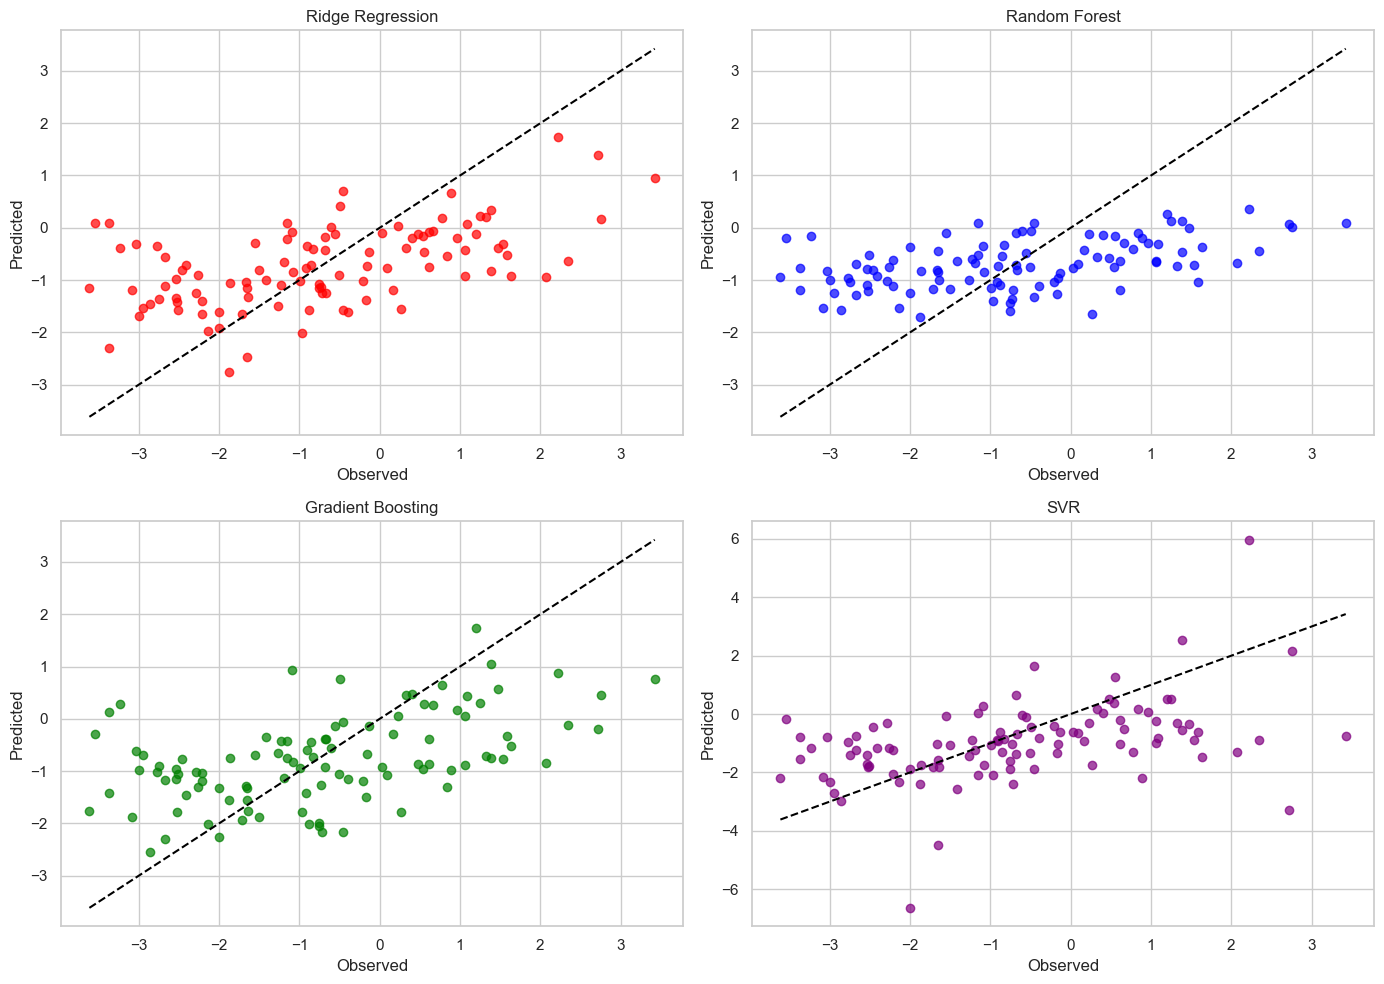

In [229]:
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(14, 10))

# Ridge Regression
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_ridge, color='red', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.title('Ridge Regression')
plt.xlabel('Observed')
plt.ylabel('Predicted')

# Random Forest
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.title('Random Forest')
plt.xlabel('Observed')
plt.ylabel('Predicted')

# Gradient Boosting
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_gb, color='green', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.title('Gradient Boosting')
plt.xlabel('Observed')
plt.ylabel('Predicted')

# Support Vector Regression
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_svr, color='purple', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.title('SVR')
plt.xlabel('Observed')
plt.ylabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()


# Spatial Prediction 

In [231]:
import pandas as pd

# Load the dataset with spatial information
df = pd.read_csv('Ethio_terraclimate_Data_scaled.csv')

# Drop unnecessary columns
df = df.drop(columns=['.geo', 'system:index', 'ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR',
                      'STATUS', 'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'Date'])

# Define features and target variable
features = ['aet', 'def', 'pet', 'pr',  'soil', 'srad', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs']
X = df[features].values
y = df['pdsi'].values

# Extract spatial coordinates if available
coordinates = df[['latitude', 'longitude']].values  # Replace with actual column names if different

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X, y, coordinates, test_size=0.2, random_state=42)

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [232]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with the best parameters
model = RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=100)

# Train the model
model.fit(X_train_scaled, y_train)


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4)

In [233]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Create a DataFrame for predictions with coordinates
predictions_df = pd.DataFrame({
    'latitude': coords_test[:, 0],
    'longitude': coords_test[:, 1],
    'observed': y_test,
    'predicted': y_pred
})


In [234]:
!pip install folium

In [235]:
import folium
from folium import plugins

# Create a base map
m = folium.Map(location=[coords_test[:, 0].mean(), coords_test[:, 1].mean()], zoom_start=6)

# Add the observed and predicted values as markers
for _, row in predictions_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if abs(row['observed'] - row['predicted']) < 0.1 else 'red',  # Example color logic
        fill=True,
        fill_color='blue' if abs(row['observed'] - row['predicted']) < 0.1 else 'red',
        fill_opacity=0.7
    ).add_to(m)

# Add a color legend (optional)
plugins.FloatImage('https://raw.githubusercontent.com/leaflet-extras/leaflet-color-markers/master/img/marker-icon.png', bottom=10, left=10).add_to(m)

# Save or display the map
m.save('spatial_predictions_map.html')


In [236]:
import folium
from folium import plugins

# Create a base map centered around the mean latitude and longitude
m = folium.Map(location=[coords_test[:, 0].mean(), coords_test[:, 1].mean()], zoom_start=6)

# Add observed and predicted values as markers
for _, row in predictions_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if abs(row['observed'] - row['predicted']) < 0.1 else 'red',  # Example color logic
        fill=True,
        fill_color='blue' if abs(row['observed'] - row['predicted']) < 0.1 else 'red',
        fill_opacity=0.7
    ).add_to(m)

# Add a color legend
legend_html = """
    <div style="
        position: fixed; 
        bottom: 50px; left: 50px; width: 120px; height: 100px; 
        background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
        ">&nbsp; <b>Legend</b><br>
        &nbsp; <i class="fa fa-circle" style="color:blue"></i> Low Error<br>
        &nbsp; <i class="fa fa-circle" style="color:red"></i> High Error<br>
    </div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save or display the map
m.save('spatial_predictions_map_with_legend.html')


In [239]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt

# Load Ethiopia's boundary shapefile or GeoJSON
ethiopia_boundary = gpd.read_file('ethiopia_boundary.shp')  # or 'ethiopia_boundary.geojson'

# Convert grid to GeoDataFrame
grid_points = np.vstack((grid_x.flatten(), grid_y.flatten())).T
grid_values = grid_z.flatten()

# Create a GeoDataFrame with grid points
grid_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in grid_points], crs="EPSG:4326")
grid_gdf['value'] = grid_values

# Clip by the boundary
clipped_gdf = gpd.clip(grid_gdf, ethiopia_boundary)

# Reshape clipped data to match grid dimensions
clipped_values = clipped_gdf['value'].values.reshape(grid_x.shape)

# Plot clipped interpolated data
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, clipped_values, cmap='viridis', levels=100)
plt.colorbar(label='Prediction')
plt.title('Clipped Interpolated Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


NameError: name 'grid_z' is not defined

In [57]:
df.head()

y  x  PDSI  Precipitation  Tmax  Tmin  AET  PET  Soil  SRAD  VPD  \
time                                                                           
1981-01-01  0  0   0.0            0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
1981-01-01  0  1   0.0            0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
1981-01-01  0  2   0.0            0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
1981-01-01  0  3   0.0            0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
1981-01-01  0  4   0.0            0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   

             VS  VAP   RO  SWE  
time                            
1981-01-01  0.0  0.0  0.0  0.0  
1981-01-01  0.0  0.0  0.0  0.0  
1981-01-01  0.0  0.0  0.0  0.0  
1981-01-01  0.0  0.0  0.0  0.0  
1981-01-01  0.0  0.0  0.0  0.0

In [49]:
df_reduced = df.drop(columns=['x','y', 'SRAD'])  # Or drop 'Tmin' based on your analysis
# Recalculate VIF after removing highly correlated variables
df_scaled_reduced = scaler.fit_transform(df_reduced)

vif_data_reduced = pd.DataFrame()
vif_data_reduced["Variable"] = df_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(df_scaled_reduced, i) for i in range(df_scaled_reduced.shape[1])]

print(vif_data_reduced)


         Variable           VIF
0            PDSI  2.905217e+00
1   Precipitation  3.325481e+01
2            Tmax  5.114715e+02
3            Tmin  1.242863e+02
4             AET  3.628412e+01
5             PET  2.156682e+06
6            Soil  9.159198e+05
7             VPD  8.806409e+04
8              VS  2.278638e+06
9             VAP  5.841054e+05
10             RO  3.160322e+02
11            SWE  4.350502e+05


In [210]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Sample data
# Ensure your actual data is loaded correctly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering and scaling
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Model setup and hyperparameter tuning
param_grid_svr = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['poly'],
    'degree': [2, 3, 4]
}

svr = SVR()
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train_scaled, y_train)

# Best SVR Params
print("Best SVR Params:", grid_search_svr.best_params_)

# Evaluate models
models = {
    'SVR': grid_search_svr.best_estimator_,
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=30),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R²: {r2}")

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('random_forest', models['Random Forest']),
        ('gradient_boosting', models['Gradient Boosting'])
    ],
    final_estimator=grid_search_svr.best_estimator_
)

stacking_regressor.fit(X_train_scaled, y_train)
y_pred_stack = stacking_regressor.predict(X_test_scaled)
stacking_mse = mean_squared_error(y_test, y_pred_stack)
stacking_r2 = r2_score(y_test, y_pred_stack)

print(f"Stacking Regressor MSE: {stacking_mse}")
print(f"Stacking Regressor R²: {stacking_r2}")



Best SVR Params: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
SVR - MSE: 1.5605326341489816, R²: 0.39636123337961904
Random Forest - MSE: 1.8691235294194861, R²: 0.2769933820863645
Gradient Boosting - MSE: 1.7295662994968182, R²: 0.330976331433282
Stacking Regressor MSE: 2.2266066436354537
Stacking Regressor R²: 0.13871324527229623


In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Only relevant for 'poly'
    'gamma': ['scale', 'auto'],  # Relevant for 'rbf', 'poly', and 'sigmoid'
    'epsilon': [0.1, 0.2, 0.3]
}

# Create SVR instance
svr = SVR()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)


Best Parameters: {'C': 10, 'degree': 2, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
Best MSE: 1.8546807555659857


In [221]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

# Define the parameter distribution
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Only relevant for 'poly'
    'gamma': ['scale', 'auto'],  # Relevant for 'rbf', 'poly', and 'sigmoid'
    'epsilon': [0.1, 0.2, 0.3]
}

# Create SVR instance
svr = SVR()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)


Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.3, 'degree': 2, 'C': 10}
Best MSE: 1.8546807555659857


In [222]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R²:", r2)


Test MSE: 1.7636033244751645
Test R²: 0.3178102704822011


# Gradient boosting fine tuning

In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb_regressor = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.9}
Best score found:  1.7870317580006798


In [225]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.8, 0.2)
}

gb_regressor = GradientBoostingRegressor()
random_search = RandomizedSearchCV(estimator=gb_regressor, param_distributions=param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)


Best parameters found:  {'learning_rate': 0.021693598373177296, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 447, 'subsample': 0.9221525934972769}
Best score found:  1.8157317649286437


In [224]:
best_gb = grid_search.best_estimator_
test_mse = mean_squared_error(y_test, best_gb.predict(X_test))
test_r2 = r2_score(y_test, best_gb.predict(X_test))

print("Test MSE: ", test_mse)
print("Test R²: ", test_r2)


Test MSE:  1.9375335938112386
Test R²:  0.25053128447289286
